# Workflow for processing Mullion-10APR19 and LKG-02JUL19 - Uncertainty Experiments

In [1]:
import time
start_time = time.time()

import numpy as np
import pandas as pd

#
# Set up input and output directories
#
mindir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/Mullion/10APR19/experiments/'
moutput = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/MUL-10APR19-UncExpt/'
lindir = '/g/data/u46/users/aw3463/GuyByrne/30APR18/Lake_George/02JUL19/experiments/'
loutput = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/LKG-02JUL19-UncExpt/'

#
# field_data is in the format: 'Field Site Name', 'Date', 'Site number', 'Satellite Name', 'Panel origin', 'Reflectance/Radiance'.
# and 'Radiance'/'Reflectance'.
# NOTE: Satellite name should be one of: 'Landsat8', 'Sentinel2a', or 'Sentinel2b'.
#
mfield_data = ['MUL', '10APR19', 'UncExpts', 'Sentinel2b', 'GA_Panel', 'Radiance', '']
lfield_data = ['LKG', '02JUL19', 'UncExpts', 'Sentinel2b', 'GA_Panel', 'Radiance', '']

#
# bad_pans    contains the names of individual panels readings that appear to be bogus
# bad_grounds contains ground-reading file names that appear to be bogus
# Use empty lists if there are no bad spectra.
#
mbad_grounds = []
mbad_pans = ['mul_exp200008.asd.rad']
lbad_grounds = []
lbad_pans = []

#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 2

#
# Calculated BRDF data
#
mbrdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.06444666666666667, 0.02135, 0.009413333333333334],
                          ['band11', 0.40661, 0.12490000000000001, 0.052866666666666666],
                          ['band12', 0.2521766666666667, 0.06437333333333334, 0.038136666666666666],
                          ['band2', 0.06444666666666667, 0.02135, 0.009413333333333334],
                          ['band3', 0.11184666666666668, 0.046783333333333336, 0.01759],
                          ['band4', 0.13019000000000003, 0.04958333333333333, 0.02087],
                          ['band5', 0.13019000000000003, 0.04958333333333333, 0.02087],
                          ['band6', 0.13019000000000003, 0.04958333333333333, 0.02087],
                          ['band7', 0.3259033333333333, 0.18528333333333333, 0.029710000000000004],
                          ['band8', 0.3259033333333333, 0.18528333333333333, 0.029710000000000004],
                          ['band8a', 0.3259033333333333, 0.18528333333333333, 0.029710000000000004],
                         ])
lbrdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.06045335991741214, 0.019734813258995294, 0.008339182599665528],
                          ['band11', 0.36533822020846624, 0.07726132347022234, 0.051200955323603775],
                          ['band12', 0.28091292682545604, 0.031590473192334566, 0.04410424565417089],
                          ['band2', 0.06045335991741214, 0.019734813258995294, 0.008339182599665528],
                          ['band3', 0.10943249669359209, 0.04153358218470896, 0.018080861612866084],
                          ['band4', 0.16843223562891532, 0.03777895997898893, 0.02825928402896155],
                          ['band5', 0.16843223562891532, 0.03777895997898893, 0.02825928402896155],
                          ['band6', 0.16843223562891532, 0.03777895997898893, 0.02825928402896155],
                          ['band7', 0.2698909731102668, 0.1396892086578475, 0.026943994029884698],
                          ['band8', 0.2698909731102668, 0.1396892086578475, 0.026943994029884698],
                          ['band8a', 0.2698909731102668, 0.1396892086578475, 0.026943994029884698],
                         ])

#
# plot_scale defines the extent of the axes in the final two plots in the workflow.
# A scale from 0-1 means no reflectance to perfect reflectance. Typically, dark sites
# will range from 0-0.3, whereas bright sites will be between 0-1.
#
plot_scale = [0.0, 0.5, 0.0, 0.5]

#
# Define corners of field data, if GPS coordinates are NOT written into headers.
# Order is SE, SW, NE, NW. Units are decimal degrees.
# If there are no coordinates, then set RockWalk to either True or False.
# True  means that the field site was walked in a rock-like pattern (alternating directions),
# False means that the field site was walked in a roll-like pattern (same direction)
#
mCorners = [0, 0, 0, 0, 0, 0, 0, 0]
RockWalk = True
StartCorner = 'SE'
lCorners = [-35.092527, 149.462373, -35.092527, 149.462373, -35.092527, 149.462373, -35.092527, 149.462373]

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import datacube
import sys, os, shutil
sys.path.append("..")

from CalVal import *

#
# Use notebook format (allows inline zooming and moving of figures)
# Set default font size for all plots
#
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['savefig.dpi'] = 300

#
# Remove old files in directory and create a new one
#
mdirectory = os.path.dirname(moutput)
if os.path.exists(mdirectory):
    shutil.rmtree(mdirectory)
os.makedirs(mdirectory)

ldirectory = os.path.dirname(loutput)
if os.path.exists(ldirectory):
    shutil.rmtree(ldirectory)
os.makedirs(ldirectory)

In [3]:
#######################################
# LINES BELOW SHOULD REMAIN UNCHANGED #
#######################################
#
# panel_dir and in_panel refer to the file that is used in determining the k-factor,
# so this should remain unchanged.
#
if mfield_data[5] == 'Radiance':
    suffix = 'asd.rad.txt'
else: 
    suffix = 'asd.txt'

panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/Panels/'

if mfield_data[4] == 'GA_Panel':
    in_panel = 'ga_panel1_jan_2018.txt'
elif mfield_data[4] == 'CSIRO_Panel':
    in_panel = 'csiro_panel.txt'
elif mfield_data[4] == 'UA_Panel':
    in_panel = 'ua_panel.txt'
elif mfield_data[4] == 'UOW_Panel':
    in_panel = 'uow_panel.txt'
elif mfield_data[4] == 'UQ_Panel':
    in_panel = 'uq_panel.txt'
elif mfield_data[4] == 'CSIRO_VIC_Panel':
    in_panel = 'csiro_vic_panel.txt'
elif mfield_data[4] == 'Curtin_Panel':
    in_panel = 'curtin_panel.txt'
else:
    nopanel = '***PANEL NAME NOT KNOWN***'
    print(nopanel)

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2b.flt'})

f_name = sat_resp[mfield_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

for i in range(50):
    colpac.append('#888888')
#
# Start Figure numbering at 1
#
fignum = 1

### Define 'alldata' as the dataframe that contains all the raw spectra.
Show the first wavelength of every spectrum, so that the data integrity can be checked.

In [4]:
malldata = LoadData.load_from_dir(mindir, suffix, firstGoodLine, mCorners)

malldata[malldata['Wavelength']==350]

Wavelength  radiance                   filename          date_saved  \
0          350  0.104209     mul_exp1a00000.asd.rad 2019-04-09 23:59:20   
0          350  0.104258     mul_exp1a00001.asd.rad 2019-04-09 23:59:24   
0          350  0.104287     mul_exp1a00002.asd.rad 2019-04-09 23:59:27   
0          350  0.104316     mul_exp1a00003.asd.rad 2019-04-09 23:59:31   
0          350  0.104296     mul_exp1a00004.asd.rad 2019-04-09 23:59:34   
0          350  0.104338     mul_exp1a00005.asd.rad 2019-04-09 23:59:38   
0          350  0.104347     mul_exp1a00006.asd.rad 2019-04-09 23:59:42   
0          350  0.104336     mul_exp1a00007.asd.rad 2019-04-09 23:59:45   
0          350  0.104429     mul_exp1a00008.asd.rad 2019-04-09 23:59:49   
0          350  0.104392     mul_exp1a00009.asd.rad 2019-04-09 23:59:52   
0          350  0.104477     mul_exp1a00010.asd.rad 2019-04-09 23:59:56   
0          350  0.104477     mul_exp1a00011.asd.rad 2019-04-10 00:00:00   
0          350  0.104496     mul_exp1a00012.asd.rad 2019-04-10 00:00:03   
0          350  0.104499     mul_exp1a00013.asd.rad 2019-04-10 00:00:07   
0          350  0.104517     mul_exp1a00014.asd.rad 2019-04-10 00:00:11   
0          350  0.104500     mul_exp1a00015.asd.rad 2019-04-10 00:00:14   
0          350  0.104550     mul_exp1a00016.asd.rad 2019-04-10 00:00:18   
0          350  0.104539     mul_exp1a00017.asd.rad 2019-04-10 00:00:21   
0          350  0.104593     mul_exp1a00018.asd.rad 2019-04-10 00:00:25   
0          350  0.104605     mul_exp1a00019.asd.rad 2019-04-10 00:00:29   
0          350  0.104626     mul_exp1a00020.asd.rad 2019-04-10 00:00:32   
0          350  0.104615     mul_exp1a00021.asd.rad 2019-04-10 00:00:36   
0          350  0.104716     mul_exp1a00022.asd.rad 2019-04-10 00:00:40   
0          350  0.104783     mul_exp1a00023.asd.rad 2019-04-10 00:00:43   
0          350  0.104879     mul_exp1a00024.asd.rad 2019-04-10 00:00:47   
0          350  0.104900     mul_exp1a00025.asd.rad 2019-04-10 00:00:50   
0          350  0.105029     mul_exp1a00026.asd.rad 2019-04-10 00:00:58   
0          350  0.105048     mul_exp1a00027.asd.rad 2019-04-10 00:01:01   
0          350  0.105074     mul_exp1a00028.asd.rad 2019-04-10 00:01:05   
0          350  0.105061     mul_exp1a00029.asd.rad 2019-04-10 00:01:08   
..         ...       ...                        ...                 ...   
0          350  0.004441  mul_exp6ln4700018.asd.rad 2019-04-10 02:51:01   
0          350  0.004499  mul_exp6ln4700019.asd.rad 2019-04-10 02:51:04   
0          350  0.004560  mul_exp6ln4700020.asd.rad 2019-04-10 02:51:08   
0          350  0.004081  mul_exp6ln4700021.asd.rad 2019-04-10 02:51:12   
0          350  0.131011  mul_exp6ln4700022.asd.rad 2019-04-10 02:51:26   
0          350  0.131198  mul_exp6ln4700023.asd.rad 2019-04-10 02:51:29   
0          350  0.131071  mul_exp6ln4900000.asd.rad 2019-04-10 02:51:58   
0          350  0.130999  mul_exp6ln4900001.asd.rad 2019-04-10 02:52:01   
0          350  0.004966  mul_exp6ln4900002.asd.rad 2019-04-10 02:52:12   
0          350  0.004431  mul_exp6ln4900003.asd.rad 2019-04-10 02:52:15   
0          350  0.005220  mul_exp6ln4900004.asd.rad 2019-04-10 02:52:19   
0          350  0.004455  mul_exp6ln4900005.asd.rad 2019-04-10 02:52:22   
0          350  0.004480  mul_exp6ln4900006.asd.rad 2019-04-10 02:52:26   
0          350  0.004261  mul_exp6ln4900007.asd.rad 2019-04-10 02:52:30   
0          350  0.005069  mul_exp6ln4900008.asd.rad 2019-04-10 02:52:33   
0          350  0.005153  mul_exp6ln4900009.asd.rad 2019-04-10 02:52:37   
0          350  0.004630  mul_exp6ln4900010.asd.rad 2019-04-10 02:52:41   
0          350  0.004844  mul_exp6ln4900011.asd.rad 2019-04-10 02:52:44   
0          350  0.004308  mul_exp6ln4900012.asd.rad 2019-04-10 02:52:55   
0          350  0.004556  mul_exp6ln4900013.asd.rad 2019-04-10 02:52:59   
0          350  0.003552  mul_exp6ln4900014.asd.rad 2019-04-10 02:53:02   
0          350  0.004078  mul

In [5]:
lalldata = LoadData.load_from_dir(lindir, suffix, firstGoodLine, lCorners)

lalldata[lalldata['Wavelength']==350]

Wavelength  radiance                   filename          date_saved  \
0          350  0.076281         eXP1A00000.asd.rad 2019-07-02 01:02:19   
0          350  0.076338         eXP1A00001.asd.rad 2019-07-02 01:02:22   
0          350  0.076408         eXP1A00002.asd.rad 2019-07-02 01:02:26   
0          350  0.076478         eXP1A00003.asd.rad 2019-07-02 01:02:29   
0          350  0.076457         eXP1A00004.asd.rad 2019-07-02 01:02:33   
0          350  0.076443         eXP1A00005.asd.rad 2019-07-02 01:02:37   
0          350  0.076385         eXP1A00006.asd.rad 2019-07-02 01:02:40   
0          350  0.076179         eXP1A00007.asd.rad 2019-07-02 01:02:44   
0          350  0.076347         eXP1A00008.asd.rad 2019-07-02 01:03:02   
0          350  0.076493         eXP1A00009.asd.rad 2019-07-02 01:03:05   
0          350  0.076606         eXP1A00010.asd.rad 2019-07-02 01:03:09   
0          350  0.076541         eXP1A00011.asd.rad 2019-07-02 01:03:12   
0          350  0.076519         eXP1A00012.asd.rad 2019-07-02 01:03:16   
0          350  0.076504         eXP1A00013.asd.rad 2019-07-02 01:03:19   
0          350  0.076517         eXP1A00014.asd.rad 2019-07-02 01:03:30   
0          350  0.076545         eXP1A00015.asd.rad 2019-07-02 01:03:34   
0          350  0.076513         eXP1A00016.asd.rad 2019-07-02 01:03:37   
0          350  0.076594         eXP1A00017.asd.rad 2019-07-02 01:03:41   
0          350  0.076642         eXP1A00018.asd.rad 2019-07-02 01:03:44   
0          350  0.076579         eXP1A00019.asd.rad 2019-07-02 01:03:48   
0          350  0.076605         eXP1A00020.asd.rad 2019-07-02 01:03:52   
0          350  0.076742         eXP1A00021.asd.rad 2019-07-02 01:03:55   
0          350  0.076747         eXP1A00022.asd.rad 2019-07-02 01:03:59   
0          350  0.076724         eXP1A00023.asd.rad 2019-07-02 01:04:03   
0          350  0.076747         eXP1A00024.asd.rad 2019-07-02 01:04:06   
0          350  0.076748         eXP1A00025.asd.rad 2019-07-02 01:04:10   
0          350  0.076759         eXP1A00026.asd.rad 2019-07-02 01:04:13   
0          350  0.076754         eXP1A00027.asd.rad 2019-07-02 01:04:17   
0          350  0.076782         eXP1A00028.asd.rad 2019-07-02 01:04:21   
0          350  0.076808         eXP1A00029.asd.rad 2019-07-02 01:04:24   
..         ...       ...                        ...                 ...   
0          350  0.005570  lkg_exp6ln4800004.asd.rad 2019-07-02 03:43:11   
0          350  0.004407  lkg_exp6ln4800005.asd.rad 2019-07-02 03:43:14   
0          350  0.005734  lkg_exp6ln4800006.asd.rad 2019-07-02 03:43:18   
0          350  0.005653  lkg_exp6ln4800007.asd.rad 2019-07-02 03:43:21   
0          350  0.005372  lkg_exp6ln4800008.asd.rad 2019-07-02 03:43:25   
0          350  0.005459  lkg_exp6ln4800009.asd.rad 2019-07-02 03:43:28   
0          350  0.068480  lkg_exp6ln4800010.asd.rad 2019-07-02 03:43:43   
0          350  0.068369  lkg_exp6ln4900000.asd.rad 2019-07-02 03:43:46   
0          350  0.004386  lkg_exp6ln4900001.asd.rad 2019-07-02 03:43:53   
0          350  0.005094  lkg_exp6ln4900002.asd.rad 2019-07-02 03:43:57   
0          350  0.005207  lkg_exp6ln4900003.asd.rad 2019-07-02 03:44:00   
0          350  0.005300  lkg_exp6ln4900004.asd.rad 2019-07-02 03:44:04   
0          350  0.005211  lkg_exp6ln4900005.asd.rad 2019-07-02 03:44:08   
0          350  0.004575  lkg_exp6ln4900006.asd.rad 2019-07-02 03:44:11   
0          350  0.005192  lkg_exp6ln4900007.asd.rad 2019-07-02 03:44:15   
0          350  0.004894  lkg_exp6ln4900008.asd.rad 2019-07-02 03:44:18   
0          350  0.004882  lkg_exp6ln4900009.asd.rad 2019-07-02 03:44:22   
0          350  0.004213  lkg_exp6ln4900010.asd.rad 2019-07-02 03:44:26   
0          350  0.004296  lkg_exp6ln5000000.asd.rad 2019-07-02 03:44:33   
0          350  0.005269  lkg_exp6ln5000001.asd.rad 2019-07-02 03:44:37   
0          350  0.005671  lkg_exp6ln5000002.asd.rad 2019-07-02 03:44:40   
0          350  0.005324  lkg

### Print out time stamp and coordinate extent for BRDF correction

The time stamp and Lat/Long extents are required to calculate the BRDF correction, used below.

In order to calculate the BRF correction, the following method is used:

<OL>
    <LI>Run the print statements in the cell below.</LI>
    <LI>Copy and paste the output into a VDI terminal window</LI>
    <LI>Copy and paste the resultant VDI output into the BRDF calculation cell, writing over the similar text.</LI>
</OL>

NOTE: This works assuming that the BRDF code is in the current directory.


In [6]:
PrintBRDF.print_brdf(malldata, mfield_data)

#################################################################################
# Copy and paste the following into a terminal window on VDI for Landsat 8 data #
#################################################################################

source module_C5.sh
sed -i "40s/.*/        self.acquisition_datetime = dateutil.parser.parse('2019-04-09 23:59:20')/" retrieve_brdf_C5.py
sed -i "43s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(148.86250166666667, -35.122971666666665, 148.86289, -35.122791666666664)]})/" retrieve_brdf_C5.py
python retrieve_brdf_C5.py > temp.txt ; awk -f format_Sent.awk temp.txt



In [7]:
mexp1a = malldata[np.logical_and(malldata.Line == 1, malldata.filename.str.match('mul_exp1a'))]
mexp1b = malldata[np.logical_and(malldata.Line == 1, malldata.filename.str.match('mul_exp1b'))]
mexp2 = malldata[np.logical_and(malldata.Line == 2, malldata.filename.str.match('mul_exp2'))]
mexp3 = malldata[np.logical_and(malldata.Line == 3, malldata.filename.str.match('mul_exp3'))]
mexp4 = malldata[np.logical_and(malldata.Line == 4, malldata.filename.str.match('mul_exp4'))]
mexp5 = malldata[np.logical_and(malldata.Line == 5, malldata.filename.str.match('mul_exp5'))]
mexp6 = malldata[np.logical_and(malldata.Line == 6, malldata.filename.str.match('mul_exp6'))]
mexp7 = malldata[np.logical_and(malldata.Line == 1, malldata.filename.str.match('mul_exp7'))]

lexp1a = lalldata[np.logical_and(lalldata.Line == 1, lalldata.filename.str.match('eXP1A'))]
lexp1b = lalldata[np.logical_and(lalldata.Line == 1, lalldata.filename.str.match('exp_1b'))]
lexp2 = lalldata[np.logical_and(lalldata.Line == 2, lalldata.filename.str.match('exp_2'))]
lexp3 = lalldata[np.logical_and(lalldata.Line == 3, lalldata.filename.str.match('exp_3'))]
lexp4 = lalldata[np.logical_and(lalldata.Line == 4, lalldata.filename.str.match('exp_4'))]
lexp5 = lalldata[np.logical_and(lalldata.Line == 5, lalldata.filename.str.match('exp_5'))]
lexp6 = lalldata[np.logical_and(lalldata.Line == 6, lalldata.filename.str.match('lkg_exp6'))]


In [8]:
from CalVal.SolarAngle import solang, add_solar

mexp1a = add_solar(mexp1a, solang)
mexp1b = add_solar(mexp1b, solang)
mexp2 = add_solar(mexp2, solang)
mexp3 = add_solar(mexp3, solang)
mexp4 = add_solar(mexp4, solang)
mexp5 = add_solar(mexp5, solang)
mexp6 = add_solar(mexp6, solang)
mexp7 = add_solar(mexp7, solang)

lexp1a = add_solar(lexp1a, solang)
lexp1b = add_solar(lexp1b, solang)
lexp2 = add_solar(lexp2, solang)
lexp3 = add_solar(lexp3, solang)
lexp4 = add_solar(lexp4, solang)
lexp5 = add_solar(lexp5, solang)
lexp6 = add_solar(lexp6, solang)

../CalVal/SolarAngle.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  good_spectra['Solar_angle'] = 1.0
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [9]:
#
# Relabel Experiment 6 with the Line numbers used within this experiment
#
# MUL
mexp6.Line = np.where(mexp6.Spec_number < 12, mexp6.filename.str[10:12].astype(int), mexp6.filename.str[10:12].astype(int)+1)
#exp6.loc[np.logical_and(exp6.Line==1, exp6.Spec_number==11), ['Line']] = 2
mexp6.loc[np.logical_and(mexp6.Line==1, mexp6.Spec_number==12), ['Line']] = 2

# LKG
lexp6.Line = lexp6.filename.str[10:12].astype(int)


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
#
# Define panel (exp6p) and ground (exp6g) dataframes for Experiment 6
#
mexp6_panel_names = mexp6[(mexp6.Wavelength==350) & (mexp6.radiance>0.05)].filename
mexp6p = mexp6.loc[mexp6.filename.isin(mexp6_panel_names)]
mexp6g = mexp6.loc[~mexp6.filename.isin(mexp6_panel_names)]

lexp6_panel_names = lexp6[(lexp6.Wavelength==350) & (lexp6.radiance>0.05)].filename
lexp6p = lexp6.loc[lexp6.filename.isin(lexp6_panel_names)]
lexp6g = lexp6.loc[~lexp6.filename.isin(lexp6_panel_names)]


In [11]:
mexp1a_spec = MakeSpecDF.make_spec_df(mexp1a, mfield_data)
mexp1b_spec = MakeSpecDF.make_spec_df(mexp1b, mfield_data)
mexp2_spec = MakeSpecDF.make_spec_df(mexp2, mfield_data)
mexp3_spec = MakeSpecDF.make_spec_df(mexp3, mfield_data)
mexp4_spec = MakeSpecDF.make_spec_df(mexp4, mfield_data)
mexp5_spec = MakeSpecDF.make_spec_df(mexp5, mfield_data)
mexp6p_spec = MakeSpecDF.make_spec_df(mexp6p, mfield_data)
mexp6g_spec = MakeSpecDF.make_spec_df(mexp6g, mfield_data)
mexp7_spec = MakeSpecDF.make_spec_df(mexp7, mfield_data)

lexp1a_spec = MakeSpecDF.make_spec_df(lexp1a, lfield_data)
lexp1b_spec = MakeSpecDF.make_spec_df(lexp1b, lfield_data)
lexp2_spec = MakeSpecDF.make_spec_df(lexp2, lfield_data)
lexp3_spec = MakeSpecDF.make_spec_df(lexp3, lfield_data)
lexp4_spec = MakeSpecDF.make_spec_df(lexp4, lfield_data)
lexp5_spec = MakeSpecDF.make_spec_df(lexp5, lfield_data)
lexp6p_spec = MakeSpecDF.make_spec_df(lexp6p, lfield_data)
lexp6g_spec = MakeSpecDF.make_spec_df(lexp6g, lfield_data)


In [12]:
#
# Remove spectrum 8 from experiment 2, which is bad. Clean up index.
#

mexp2.reset_index(drop=True, inplace=True)
mexp2 = mexp2.drop(mexp2[mexp2.Spec_number==8].index)

mexp2_spec.drop('radiance2-8', axis=1, inplace=True)
mexp2.set_index('Wavelength', inplace=True)



In [13]:
mexp1a_mean = mexp1a_spec.mean(axis=1)
mexp1b_mean = mexp1b_spec.mean(axis=1)
mexp2_mean = mexp2_spec.mean(axis=1)
mexp3_mean = mexp3_spec.mean(axis=1)
mexp4_mean = mexp4_spec.mean(axis=1)
mexp5_mean = mexp5_spec.mean(axis=1)
mexp6p_mean = mexp6p_spec.mean(axis=1)
mexp6g_mean = mexp6g_spec.mean(axis=1)
mexp7_mean = mexp7_spec.mean(axis=1)

lexp1a_mean = lexp1a_spec.mean(axis=1)
lexp1b_mean = lexp1b_spec.mean(axis=1)
lexp2_mean = lexp2_spec.mean(axis=1)
lexp3_mean = lexp3_spec.mean(axis=1)
lexp4_mean = lexp4_spec.mean(axis=1)
lexp5_mean = lexp5_spec.mean(axis=1)
lexp6p_mean = lexp6p_spec.mean(axis=1)
lexp6g_mean = lexp6g_spec.mean(axis=1)

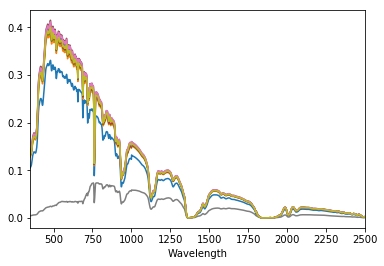

In [14]:
mexp1a_mean.plot()
mexp1b_mean.plot()
mexp2_mean.plot()
mexp3_mean.plot()
mexp4_mean.plot()
mexp5_mean.plot()
mexp6p_mean.plot()
mexp6g_mean.plot()
mexp7_mean.plot()

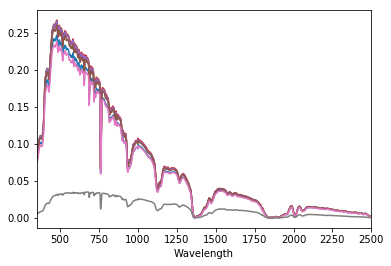

In [15]:
lexp1a_mean.plot()
lexp1b_mean.plot()
lexp2_mean.plot()
lexp3_mean.plot()
lexp4_mean.plot()
lexp5_mean.plot()
lexp6p_mean.plot()
lexp6g_mean.plot()

In [16]:
def masky(meanie):
    mask1 = meanie.where(np.logical_or(meanie.index<1300, meanie.index>1550))
    mask2 = mask1.where(np.logical_or(mask1.index<1760, mask1.index>2030))
    mask3 = mask2.where(mask2.index>450)
    mask4 = mask3.where(np.logical_or(mask3.index<750, mask3.index>770))
    mask5 = mask4.where(np.logical_or(mask4.index<880, mask4.index>1020))
    mask6 = mask5.where(np.logical_or(mask5.index<1080, mask5.index>1170))
    mask7 = mask6.where(np.logical_or(mask6.index<680, mask6.index>700))
    mask8 = mask7.where(np.logical_or(mask7.index<710, mask7.index>735))
    mask9 = mask8.where(np.logical_or(mask8.index<810, mask8.index>840))
    meanie_masked = mask9.where(np.logical_or(mask9.index<2250, mask9.index>2500))
    return meanie_masked

mexp1a_mean_masked = masky(mexp1a_mean)
mexp1b_mean_masked = masky(mexp1b_mean)
mexp2_mean_masked = masky(mexp2_mean)
mexp3_mean_masked = masky(mexp3_mean)
mexp4_mean_masked = masky(mexp4_mean)
mexp5_mean_masked = masky(mexp5_mean)
mexp6p_mean_masked = masky(mexp6p_mean)
mexp6g_mean_masked = masky(mexp6g_mean)
mexp7_mean_masked = masky(mexp7_mean)

lexp1a_mean_masked = masky(lexp1a_mean)
lexp1b_mean_masked = masky(lexp1b_mean)
lexp2_mean_masked = masky(lexp2_mean)
lexp3_mean_masked = masky(lexp3_mean)
lexp4_mean_masked = masky(lexp4_mean)
lexp5_mean_masked = masky(lexp5_mean)
lexp6p_mean_masked = masky(lexp6p_mean)
lexp6g_mean_masked = masky(lexp6g_mean)

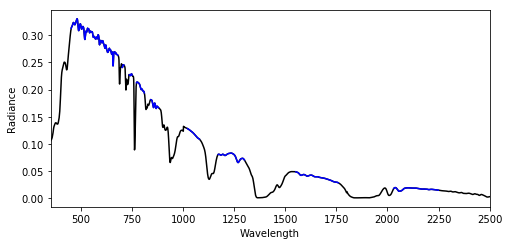

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 4.0))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

mexp1a_mean.plot(ax=axes, color='black')
mexp1a_mean_masked.plot(ax=axes, color='blue')
axes.set_ylabel('Radiance')
plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/MeanSpec.png')

Text(40.5, 0.5, 'Radiance')

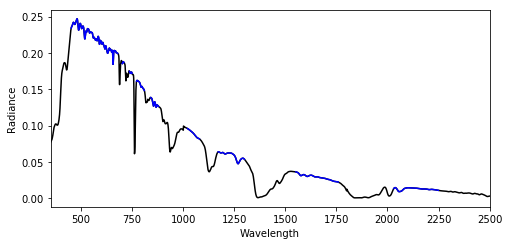

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 4.0))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

lexp1a_mean.plot(ax=axes, color='black')
lexp1a_mean_masked.plot(ax=axes, color='blue')
axes.set_ylabel('Radiance')
#plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/MeanSpec.png')

In [19]:
mexp1a_norm = mexp1a_spec.div(mexp1a_mean_masked, axis=0)
mexp1b_norm = mexp1b_spec.div(mexp1b_mean_masked, axis=0)
mexp2_norm = mexp2_spec.div(mexp2_mean_masked, axis=0)
mexp3_norm = mexp3_spec.div(mexp3_mean_masked, axis=0)
mexp4_norm = mexp4_spec.div(mexp4_mean_masked, axis=0)
mexp5_norm = mexp5_spec.div(mexp5_mean_masked, axis=0)
mexp6p_norm = mexp6p_spec.div(mexp6p_mean_masked, axis=0)
mexp6g_norm = mexp6g_spec.div(mexp6g_mean_masked, axis=0)
mexp7_norm = mexp7_spec.div(mexp7_mean_masked, axis=0)

lexp1a_norm = lexp1a_spec.div(lexp1a_mean_masked, axis=0)
lexp1b_norm = lexp1b_spec.div(lexp1b_mean_masked, axis=0)
lexp2_norm = lexp2_spec.div(lexp2_mean_masked, axis=0)
lexp3_norm = lexp3_spec.div(lexp3_mean_masked, axis=0)
lexp4_norm = lexp4_spec.div(lexp4_mean_masked, axis=0)
lexp5_norm = lexp5_spec.div(lexp5_mean_masked, axis=0)
lexp6p_norm = lexp6p_spec.div(lexp6p_mean_masked, axis=0)
lexp6g_norm = lexp6g_spec.div(lexp6g_mean_masked, axis=0)

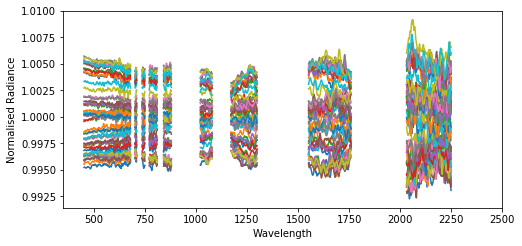

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 4.0))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

mexp1a_norm.plot(ax=axes, legend=False)
axes.set_ylabel('Normalised Radiance')

plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/NormSpec.png')

Text(40.5, 0.5, 'Normalised Radiance')

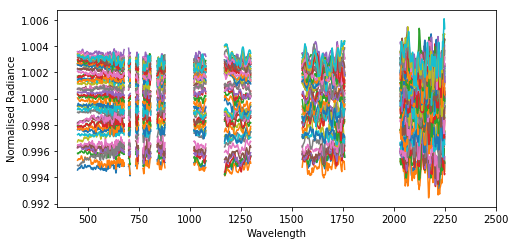

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 4.0))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

lexp1a_norm.plot(ax=axes, legend=False)
axes.set_ylabel('Normalised Radiance')

#plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/NormSpec.png')

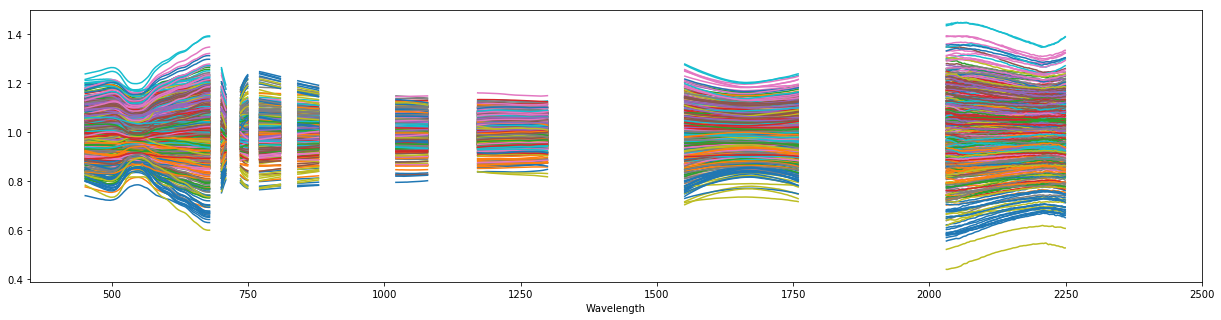

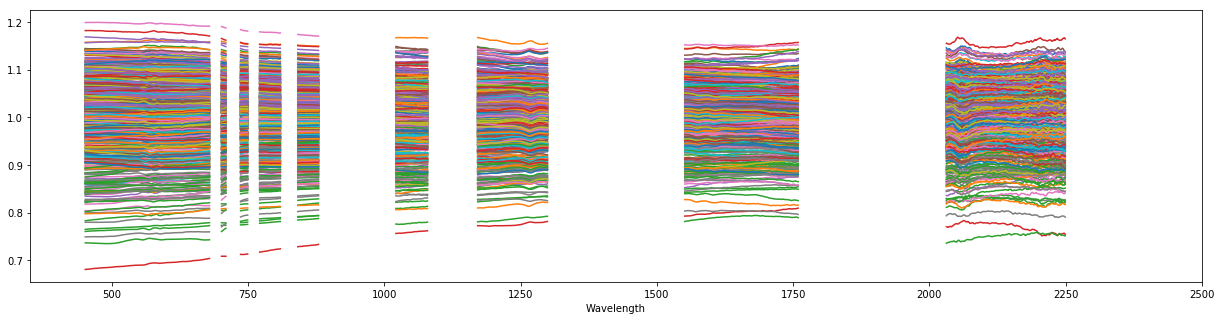

In [22]:
mexp6g_norm.plot(legend=False, figsize=(21,5), xlim=(350,2500))
lexp6g_norm.plot(legend=False, figsize=(21,5), xlim=(350,2500))

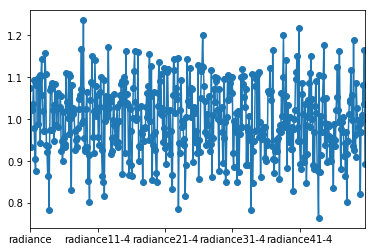

In [23]:
mexp6g_norm.mean().plot(style='-o')

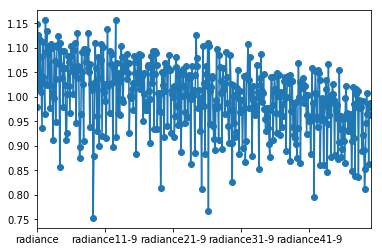

In [24]:
lexp6g_norm.mean().plot(style='-o')

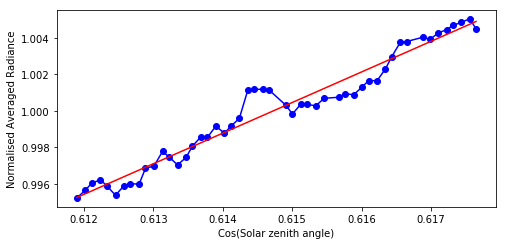

In [25]:
from scipy.stats import linregress

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 4.0))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

coszenith = np.cos(np.deg2rad(mexp1a[mexp1a.index==350].Solar_angle))
slope, intercept, r_value, p_value, std_err = linregress(coszenith, mexp1a_norm.mean())
plt.plot(coszenith, mexp1a_norm.mean(), color='blue', marker='o')
plt.plot(coszenith, (slope*coszenith)+intercept, color='red')
axes.set_xlabel('Cos(Solar zenith angle)')
axes.set_ylabel('Normalised Averaged Radiance')

plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/FitSpec.png')

Text(40.5, 0.5, 'Normalised Averaged Radiance')

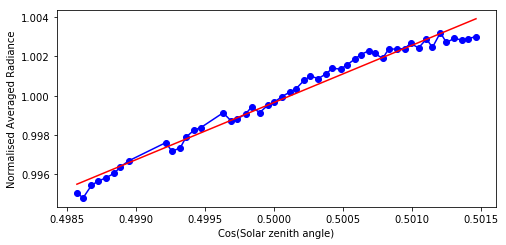

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 4.0))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

coszenith = np.cos(np.deg2rad(lexp1a[lexp1a.index==350].Solar_angle))
slope, intercept, r_value, p_value, std_err = linregress(coszenith, lexp1a_norm.mean())
plt.plot(coszenith, lexp1a_norm.mean(), color='blue', marker='o')
plt.plot(coszenith, (slope*coszenith)+intercept, color='red')
axes.set_xlabel('Cos(Solar zenith angle)')
axes.set_ylabel('Normalised Averaged Radiance')

#plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/FitSpec.png')

In [27]:
from scipy.stats import linregress

def fitnstuff(exp, exp_norm):
    coszenith = np.cos(np.deg2rad(exp[exp.index==350].Solar_angle))
    slope, intercept, r_value, p_value, std_err = linregress(coszenith, exp_norm.mean())
    plt.plot(coszenith, (slope*coszenith)+intercept, color='red')
    plt.scatter(coszenith, exp_norm.mean(), color='blue', marker='o')
    
    stum = []
    for i in range(len(coszenith)):
        stum.append((exp_norm.mean()[i]) - ((slope*coszenith.iloc[i])+intercept))
        
    stor = pd.Series(stum)
    return stor

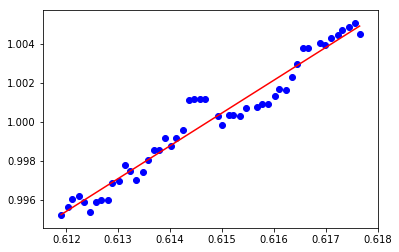

In [28]:
mexp1a_var = fitnstuff(mexp1a, mexp1a_norm)*100

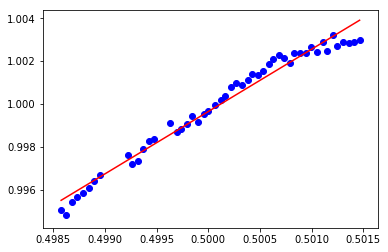

In [29]:
lexp1a_var = fitnstuff(lexp1a, lexp1a_norm)*100

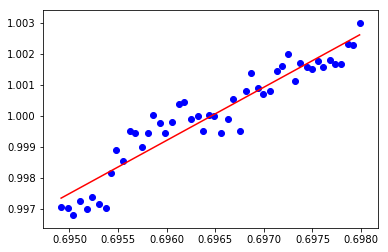

In [30]:
mexp1b_var = fitnstuff(mexp1b, mexp1b_norm)*100

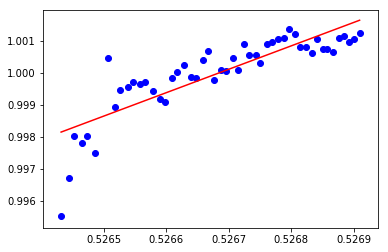

In [31]:
lexp1b_var = fitnstuff(lexp1b, lexp1b_norm)*100

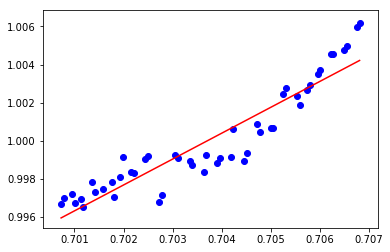

In [32]:
mexp2_var = fitnstuff(mexp2, mexp2_norm)*100

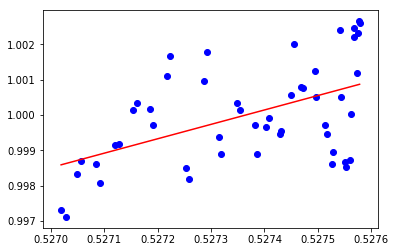

In [33]:
lexp2_var = fitnstuff(lexp2, lexp2_norm)*100

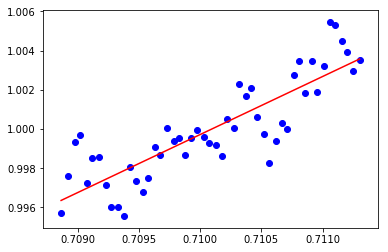

In [34]:
mexp3_var = fitnstuff(mexp3, mexp3_norm)*100

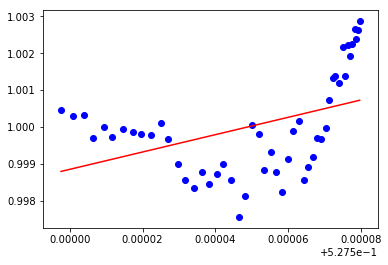

In [35]:
lexp3_var = fitnstuff(lexp3, lexp3_norm)*100

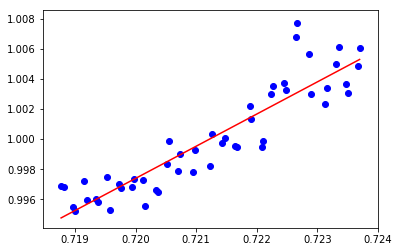

In [36]:
mexp4_var = fitnstuff(mexp4, mexp4_norm)*100

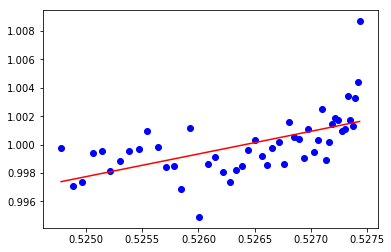

In [37]:
lexp4_var = fitnstuff(lexp4, lexp4_norm)*100

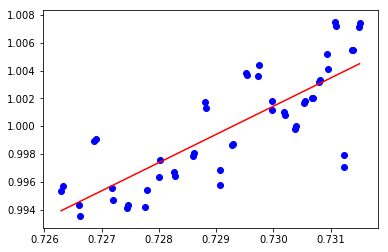

In [38]:
mexp5_var = fitnstuff(mexp5, mexp5_norm)*100

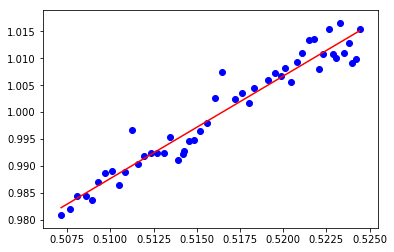

In [39]:
lexp5_var = fitnstuff(lexp5, lexp5_norm)*100

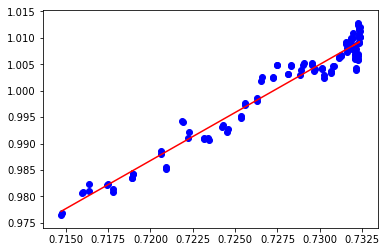

In [40]:
mexp6p_var = fitnstuff(mexp6p, mexp6p_norm)*100

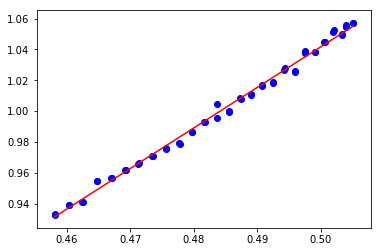

In [41]:
lexp6p_var = fitnstuff(lexp6p, lexp6p_norm)*100

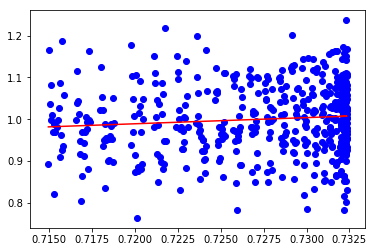

In [42]:
mexp6g_var = fitnstuff(mexp6g, mexp6g_norm)*100

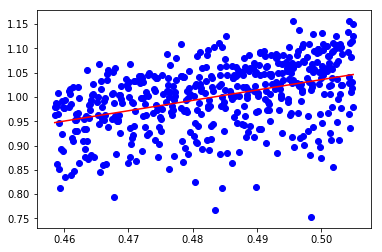

In [43]:
lexp6g_var = fitnstuff(lexp6g, lexp6g_norm)*100

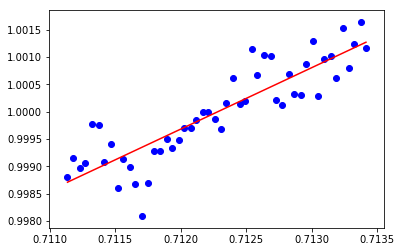

In [44]:
mexp7_var = fitnstuff(mexp7, mexp7_norm)*100

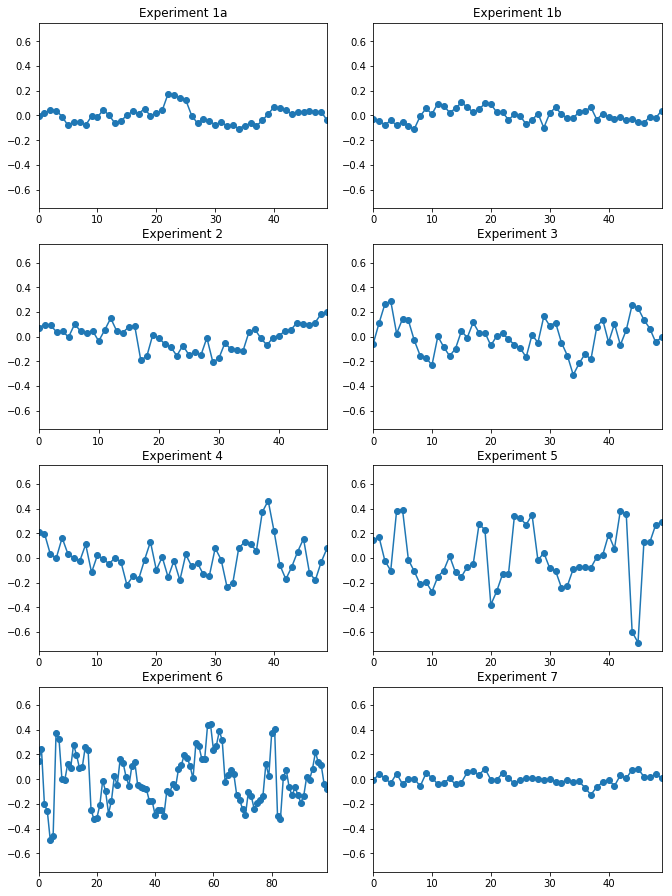

In [45]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9.5, 12.5))
plt.tight_layout(pad=1.5, w_pad=1.5, h_pad=1.5)

mexp1a_var.plot(ax=axes[0,0], style='-o', ylim=(-0.75, 0.75), title='Experiment 1a')
mexp1b_var.plot(ax=axes[0,1], style='-o', ylim=(-0.75, 0.75), title='Experiment 1b')
mexp2_var.plot(ax=axes[1,0], style='-o', ylim=(-0.75, 0.75), title='Experiment 2')
mexp3_var.plot(ax=axes[1,1], style='-o', ylim=(-0.75, 0.75), title='Experiment 3')
mexp4_var.plot(ax=axes[2,0], style='-o', ylim=(-0.75, 0.75), title='Experiment 4')
mexp5_var.plot(ax=axes[2,1], style='-o', ylim=(-0.75, 0.75), title='Experiment 5')
mexp6p_var.plot(ax=axes[3,0], style='-o', ylim=(-0.75, 0.75), title='Experiment 6')
mexp7_var.plot(ax=axes[3,1], style='-o', ylim=(-0.75, 0.75), title='Experiment 7')

plt.savefig('expts.png')

(0.0, 1.0, 0.0, 1.0)

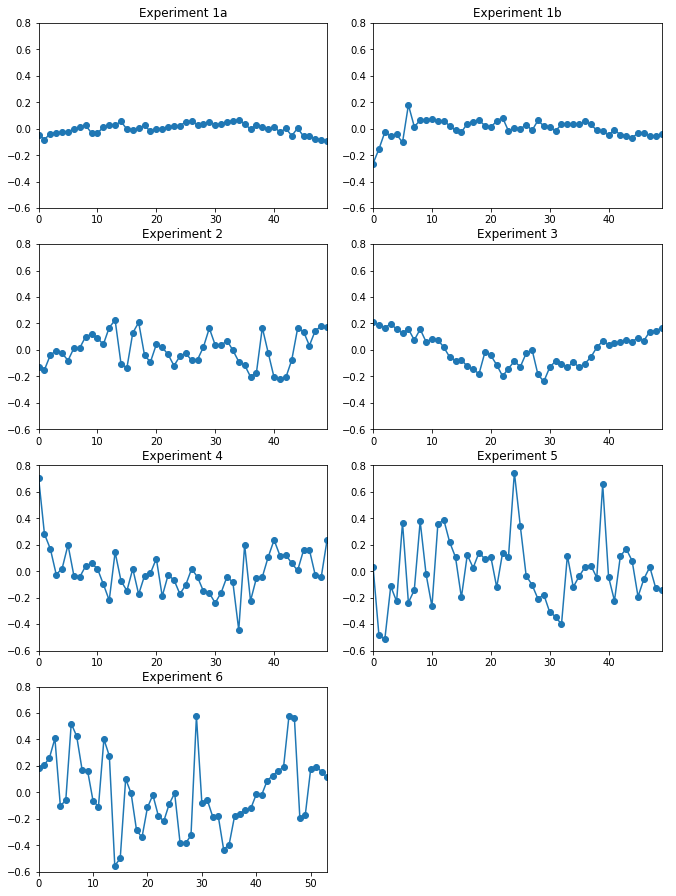

In [46]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(9.5, 12.5))
plt.tight_layout(pad=1.5, w_pad=1.5, h_pad=1.5)

lexp1a_var.plot(ax=axes[0,0], style='-o', ylim=(-0.6, 0.8), title='Experiment 1a')
lexp1b_var.plot(ax=axes[0,1], style='-o', ylim=(-0.6, 0.8), title='Experiment 1b')
lexp2_var.plot(ax=axes[1,0], style='-o', ylim=(-0.6, 0.8), title='Experiment 2')
lexp3_var.plot(ax=axes[1,1], style='-o', ylim=(-0.6, 0.8), title='Experiment 3')
lexp4_var.plot(ax=axes[2,0], style='-o', ylim=(-0.6, 0.8), title='Experiment 4')
lexp5_var.plot(ax=axes[2,1], style='-o', ylim=(-0.6, 0.8), title='Experiment 5')
lexp6p_var.plot(ax=axes[3,0], style='-o', ylim=(-0.6, 0.8), title='Experiment 6')
axes[3,1].axis('off')


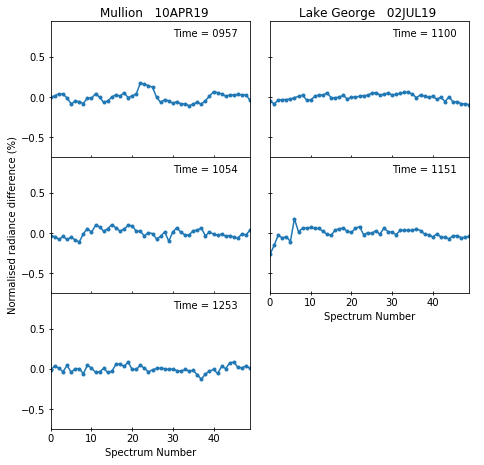

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7.5, 7.5))
fig.subplots_adjust(hspace=0.0, wspace=0.1)

#plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.5)

mexp1a_var.plot(ax=axes[0,0], style='-o', ms=3, ylim=(-0.74, 0.95))
mexp1b_var.plot(ax=axes[1,0], style='-o', ms=3, ylim=(-0.74, 0.95))
mexp7_var.plot(ax=axes[2,0], style='-o', ms=3, ylim=(-0.74, 0.95))

axes[2,0].set_xlabel('Spectrum Number')
axes[1,0].set_ylabel('Normalised radiance difference (%)')
axes[0,0].xaxis.set_ticklabels([])
axes[1,0].xaxis.set_ticklabels([])
axes[0,0].xaxis.set_ticks([10, 20, 30, 40])
axes[0,0].tick_params(direction='inout')
axes[1,0].tick_params(direction='inout')
axes[2,0].tick_params(direction='inout')
axes[0,0].text(30, 0.75,'Time = 0957')
axes[1,0].text(30, 0.75,'Time = 1054')
axes[2,0].text(30, 0.75,'Time = 1253')

#plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/MUL-ExptA.png')

#fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7.5, 7.5))
#fig.subplots_adjust(hspace=0.0, wspace=1.0)

##plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.5)

lexp1a_var.plot(ax=axes[0,1], style='-o', ms=3, ylim=(-0.74, 0.95))
lexp1b_var.plot(ax=axes[1,1], style='-o', ms=3, ylim=(-0.74, 0.95))

axes[1,1].set_xlabel('Spectrum Number')
#axes[1,1].set_ylabel('Normalised radiance difference (%)')
axes[0,1].xaxis.set_ticklabels([])
axes[0,1].xaxis.set_ticks([10, 20, 30, 40])
axes[0,1].tick_params(direction='inout')
axes[1,1].tick_params(direction='inout')
axes[0,1].text(30, 0.75,'Time = 1100')
axes[1,1].text(30, 0.75,'Time = 1151')
axes[1,1].yaxis.set_label_coords(-0.09,1)
axes[2,1].axis('off')
axes[0,1].yaxis.set_ticklabels([])
axes[1,1].yaxis.set_ticklabels([])
axes[0,0].text(12, 1.0, 'Mullion   10APR19', fontsize=12)
axes[0,1].text(7, 1.0, 'Lake George   02JUL19', fontsize=12)

plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/ExptA.png', dpi=300)

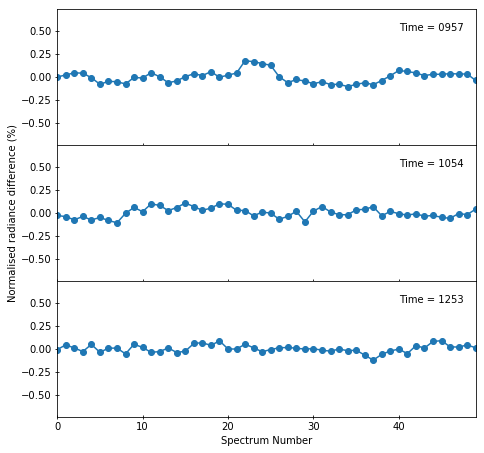

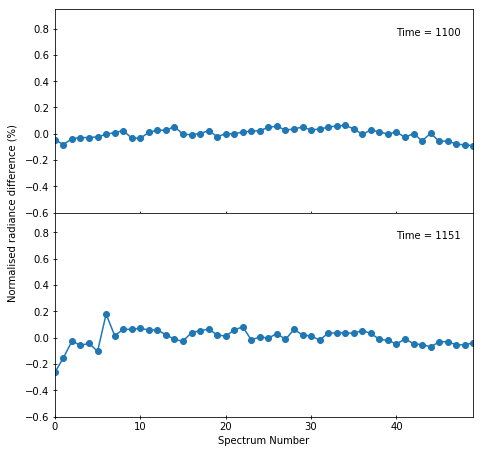

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7.5, 7.5))
fig.subplots_adjust(hspace=0.0, wspace=1.0)

#plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.5)

mexp1a_var.plot(ax=axes[0], style='-o', ylim=(-0.74, 0.74))
mexp1b_var.plot(ax=axes[1], style='-o', ylim=(-0.74, 0.74))
mexp7_var.plot(ax=axes[2], style='-o', ylim=(-0.74, 0.74))

axes[2].set_xlabel('Spectrum Number')
axes[1].set_ylabel('Normalised radiance difference (%)')
axes[0].xaxis.set_ticklabels([])
axes[1].xaxis.set_ticklabels([])
axes[0].xaxis.set_ticks([10, 20, 30, 40])
axes[0].tick_params(direction='inout')
axes[1].tick_params(direction='inout')
axes[2].tick_params(direction='inout')
axes[0].text(40, 0.5,'Time = 0957')
axes[1].text(40, 0.5,'Time = 1054')
axes[2].text(40, 0.5,'Time = 1253')

plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/MUL-ExptA.png')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7.5, 7.5))
fig.subplots_adjust(hspace=0.0, wspace=1.0)

#plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.5)

lexp1a_var.plot(ax=axes[0], style='-o', ylim=(-0.6, 0.95))
lexp1b_var.plot(ax=axes[1], style='-o', ylim=(-0.6, 0.95))

axes[1].set_xlabel('Spectrum Number')
axes[1].set_ylabel('Normalised radiance difference (%)')
axes[0].xaxis.set_ticklabels([])
axes[0].xaxis.set_ticks([10, 20, 30, 40])
axes[0].tick_params(direction='inout')
axes[1].tick_params(direction='inout')
axes[0].text(40, 0.75,'Time = 1100')
axes[1].text(40, 0.75,'Time = 1151')
axes[1].yaxis.set_label_coords(-0.09,1)
plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/LKG-ExptA.png')

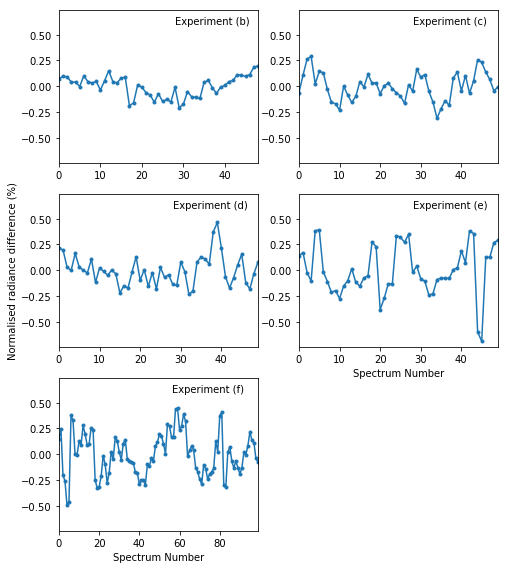

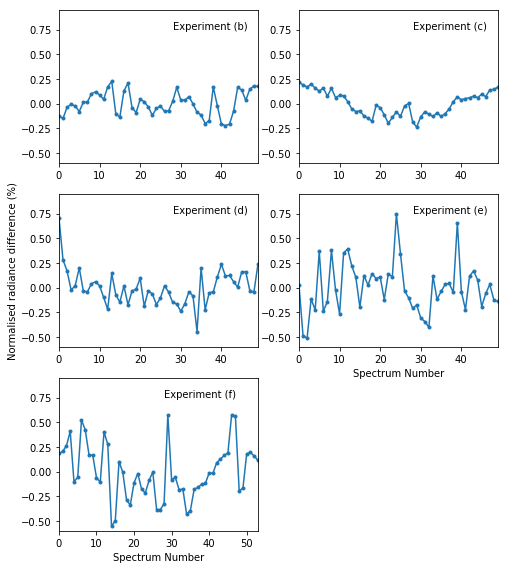

In [49]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7.5, 8.5))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

mexp2_var.plot(ax=axes[0,0], style='-o', ms=3, ylim=(-0.74, 0.74))
mexp3_var.plot(ax=axes[0,1], style='-o', ms=3, ylim=(-0.74, 0.74))
mexp4_var.plot(ax=axes[1,0], style='-o', ms=3, ylim=(-0.74, 0.74))
mexp5_var.plot(ax=axes[1,1], style='-o', ms=3, ylim=(-0.74, 0.74))
mexp6p_var.plot(ax=axes[2,0], style='-o', ms=3, ylim=(-0.74, 0.74))

axes[2,1].axis('off')
axes[2,0].set_xlabel('Spectrum Number')
axes[1,1].set_xlabel('Spectrum Number')
axes[1,0].set_ylabel('Normalised radiance difference (%)')

axes[0,0].text(28, 0.6,'Experiment (b)')
axes[0,1].text(28, 0.6,'Experiment (c)')
axes[1,0].text(28, 0.6,'Experiment (d)')
axes[1,1].text(28, 0.6,'Experiment (e)')
axes[2,0].text(56, 0.6,'Experiment (f)')

plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/MUL-ExptB-F.png')


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(7.5, 8.5))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

lexp2_var.plot(ax=axes[0,0], style='-o', ms=3, ylim=(-0.6, 0.95))
lexp3_var.plot(ax=axes[0,1], style='-o', ms=3, ylim=(-0.6, 0.95))
lexp4_var.plot(ax=axes[1,0], style='-o', ms=3, ylim=(-0.6, 0.95))
lexp5_var.plot(ax=axes[1,1], style='-o', ms=3, ylim=(-0.6, 0.95))
lexp6p_var.plot(ax=axes[2,0], style='-o', ms=3, ylim=(-0.6, 0.95))

axes[2,1].axis('off')
axes[2,0].set_xlabel('Spectrum Number')
axes[1,1].set_xlabel('Spectrum Number')
axes[1,0].set_ylabel('Normalised radiance difference (%)')

axes[0,0].text(28, 0.75,'Experiment (b)')
axes[0,1].text(28, 0.75,'Experiment (c)')
axes[1,0].text(28, 0.75,'Experiment (d)')
axes[1,1].text(28, 0.75,'Experiment (e)')
axes[2,0].text(28, 0.75,'Experiment (f)')

plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/LKG-ExptB-F.png')

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


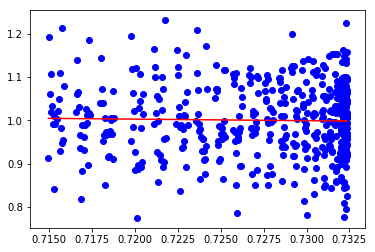

In [50]:
#
# This cell rescales the ground spectra for experiment 6, based on the panel spectra for the
# same experiment. Note: this cell should only be run once, otherwise the correction is applied
# twice and the radiances will be wrong!
#

coszenith = np.cos(np.deg2rad(mexp6p[mexp6p.index==350].Solar_angle))
slope, intercept, r_value, p_value, std_err = linregress(coszenith, mexp6p_norm.mean())

coszenith = np.cos(np.deg2rad(mexp6g.Solar_angle))
mexp6g.radiance = mexp6g.radiance/((slope*coszenith)+intercept)

mexp6g_spec = MakeSpecDF.make_spec_df(mexp6g, mfield_data)
mexp6g_mean = mexp6g_spec.mean(axis=1)
mexp6g_mean_masked = masky(mexp6g_mean)
mexp6g_norm = mexp6g_spec.div(mexp6g_mean_masked, axis=0)
mexp6g_var = fitnstuff(mexp6g, mexp6g_norm)*100

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


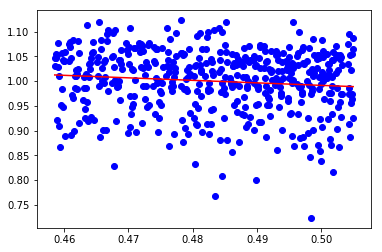

In [51]:
coszenith = np.cos(np.deg2rad(lexp6p[lexp6p.index==350].Solar_angle))
slope, intercept, r_value, p_value, std_err = linregress(coszenith, lexp6p_norm.mean())

coszenith = np.cos(np.deg2rad(lexp6g.Solar_angle))
lexp6g.radiance = lexp6g.radiance/((slope*coszenith)+intercept)

lexp6g_spec = MakeSpecDF.make_spec_df(lexp6g, lfield_data)
lexp6g_mean = lexp6g_spec.mean(axis=1)
lexp6g_mean_masked = masky(lexp6g_mean)
lexp6g_norm = lexp6g_spec.div(lexp6g_mean_masked, axis=0)
lexp6g_var = fitnstuff(lexp6g, lexp6g_norm)*100

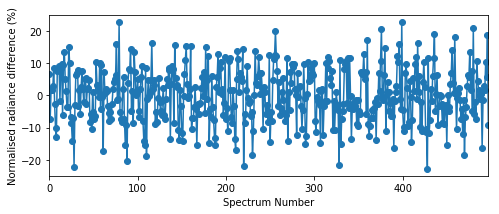

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 3.5))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

mexp6g_var.plot(ax=axes, style='-o', ylim=(-25, 25))

axes.set_xlabel('Spectrum Number')
axes.set_ylabel('Normalised radiance difference (%)')

plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/MUL-ExptF_ground.png')

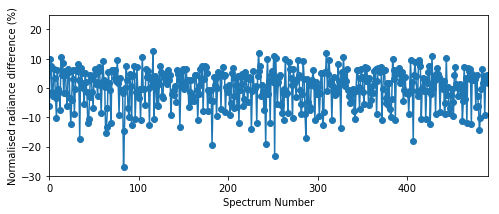

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 3.5))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

lexp6g_var.plot(ax=axes, style='-o', ylim=(-30, 25))

axes.set_xlabel('Spectrum Number')
axes.set_ylabel('Normalised radiance difference (%)')

plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/LKG-ExptF_ground.png')

In [54]:
mplx = pd.DataFrame(mexp6g_norm.mean())
mplx['Line'] = mexp6g[mexp6g.Wavelength==350].Line.values
mplx['Spec_number'] = mexp6g[mexp6g.Wavelength==350].Spec_number.values

lplx = pd.DataFrame(lexp6g_norm.mean())
lplx['Line'] = lexp6g[lexp6g.Wavelength==350].Line.values
lplx['Spec_number'] = lexp6g[lexp6g.Wavelength==350].Spec_number.values

In [55]:
mplx.columns=['Radiance', 'Line', 'Spec_number']
mplx.set_index('Spec_number', inplace=True)
lplx.columns=['Radiance', 'Line', 'Spec_number']
lplx.set_index('Spec_number', inplace=True)

In [56]:
mplxd = mplx.copy()
mplxd.Radiance = (mplxd.Radiance-1)*100
lplxd = lplx.copy()
lplxd.Radiance = (lplxd.Radiance-1)*100

odd lines: -1.1453050149430322 ± 1.4541159126607444 even lines: 0.9647091533868385 ± 1.3127579448547428


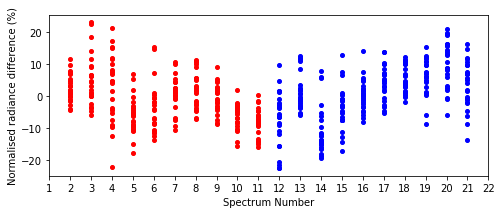

In [57]:
aa, bb, cc, dd = [], [], [], []
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 3.5))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

for i in mplxd.Line.unique():
    if i==1 or i==2:
        continue
    if i%2==0:
        mplxd[mplxd.Line==i].Radiance.plot(ax=axes, style='bo', ms=4)#, ylim=(-25,25))
        bb.append(mplxd[mplxd.Line==i].Radiance.mean())
    else:
        mplxd[mplxd.Line==i].Radiance.plot(ax=axes, style='ro', ms=4)#, ylim=(-25,25))
        aa.append(mplxd[mplxd.Line==i].Radiance.mean())
    
for i in range(2):
    cc.append(np.nan)
    dd.append(np.nan)
for i in mplxd.index.unique():
    cc.append(mplxd[mplxd.index==i].Radiance.median())
    dd.append(mplxd[mplxd.index==i].Radiance.mean())
#pd.Series(cc).plot(ax=axes, style='ko', ms=15, fillstyle='none')
#pd.Series(dd).plot(ax=axes, style='ko', ms=15, fillstyle='none')

        
axes.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22])
axes.set_xlabel('Spectrum Number')
axes.set_ylabel('Normalised radiance difference (%)')
plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/MirrSpec.png')
print("odd lines:", pd.Series(aa).mean(), u"\u00B1", pd.Series(aa).std(), "even lines:", pd.Series(bb).mean(), u"\u00B1", pd.Series(bb).std())

odd lines: 0.9970667850734363 ± 0.012774731328195545 even lines: 1.0024381606281876 ± 0.01705267465416813


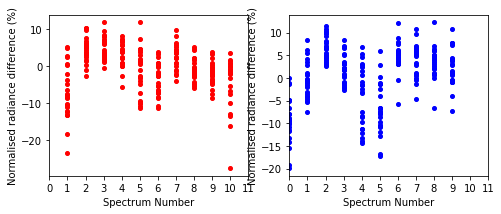

In [58]:
aa, bb = [], []
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 3.5))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

for i in lplxd.Line.unique():
    if i==1 or i==2:
        continue
    if i%2==0:
        lplxd[lplxd.Line==i].Radiance.plot(ax=axes[1], style='bo', ms=4)#, ylim=(-25,25))
        bb.append(lplx[lplx.Line==i].Radiance.mean())
    else:
        lplxd[lplxd.Line==i].Radiance.plot(ax=axes[0], style='ro', ms=4)#, ylim=(-25,25))
        aa.append(lplx[lplx.Line==i].Radiance.mean())
    
axes[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[0].set_xlabel('Spectrum Number')
axes[0].set_ylabel('Normalised radiance difference (%)')
axes[1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[1].set_xlabel('Spectrum Number')
axes[1].set_ylabel('Normalised radiance difference (%)')
#plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/MirrSpec.png')
print("odd lines:", pd.Series(aa).mean(), u"\u00B1", pd.Series(aa).std(), "even lines:", pd.Series(bb).mean(), u"\u00B1", pd.Series(bb).std())

In [59]:
mplxm = mplxd.copy()
mplxm.index = mplxd.index - ((mplxd.index - 11.5)*2)

lplxm = lplxd.copy()
lplxm.index = 10 - lplxd.index

odd lines: -1.1453050149430322 ± 1.4541159126607444 even lines: 0.9647091533868385 ± 1.3127579448547428


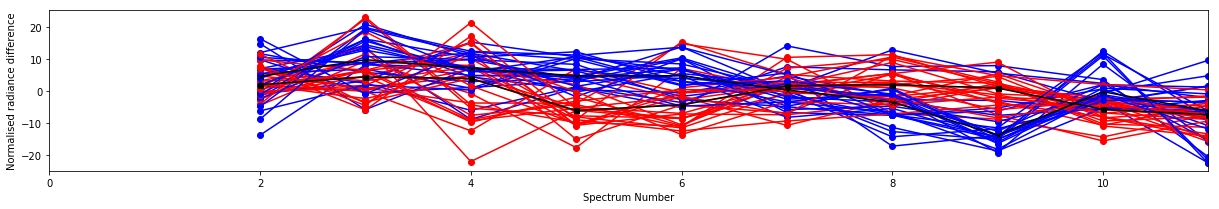

In [60]:
aa, bb, cc, dd = [], [], [], []
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(17.5, 3.5))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

for i in mplxd.Line.unique():
    if i==1 or i==2:
        continue
    if i%2==0:
        mplxm[mplxm.Line==i].Radiance.plot(ax=axes, style='b-o')#, ylim=(-25,25))
        bb.append(mplxm[mplxm.Line==i].Radiance.mean())
    else:
        mplxd[mplxd.Line==i].Radiance.plot(ax=axes, style='r-o')#, ylim=(-25,25))
        aa.append(mplxd[mplxd.Line==i].Radiance.mean())

for i in range(2):
    cc.append(np.nan)
    dd.append(np.nan)
for i in range(2,12):
    cc.append(mplxd[mplxd.index==i].Radiance.median())
    dd.append(mplxm[mplxm.index==i].Radiance.median())
pd.Series(cc).plot(ax=axes, style='k-s', ms=5)
pd.Series(dd).plot(ax=axes, style='k-x', ms=5)

axes.set_xlabel('Spectrum Number')
axes.set_ylabel('Normalised radiance difference')
print("odd lines:", pd.Series(aa).mean(), u"\u00B1", pd.Series(aa).std(), "even lines:", pd.Series(bb).mean(), u"\u00B1", pd.Series(bb).std())

odd lines: -0.29332149265639074 ± 1.277473132819556 even lines: 0.2438160628187663 ± 1.7052674654168154


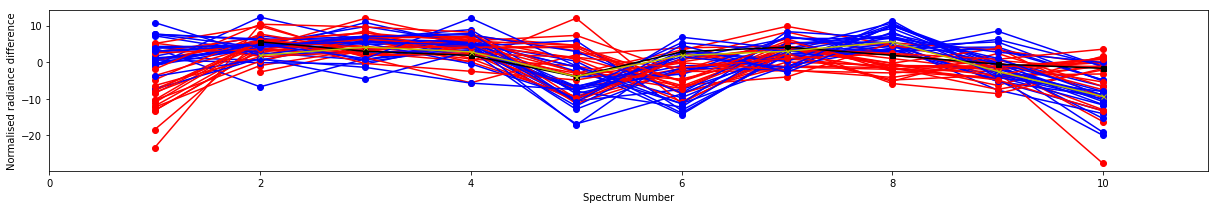

In [61]:
aa, bb, cc, dd = [], [], [], []
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(17.5, 3.5))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

for i in lplxd.Line.unique():
    if i==1 or i==2:
        continue
    if i%2==0:
        lplxm[lplxm.Line==i].Radiance.plot(ax=axes, style='b-o')#, ylim=(-25,25))
        bb.append(lplxm[lplxm.Line==i].Radiance.mean())
    else:
        lplxd[lplxd.Line==i].Radiance.plot(ax=axes, style='r-o')#, ylim=(-25,25))
        aa.append(lplxd[lplxd.Line==i].Radiance.mean())

for i in range(2):
    cc.append(np.nan)
    dd.append(np.nan)
for i in range(2,12):
    cc.append(lplxd[lplxd.index==i].Radiance.median())
    dd.append(lplxm[lplxm.index==i].Radiance.median())
pd.Series(cc).plot(ax=axes, style='k-s', ms=5)
pd.Series(dd).plot(ax=axes, style='y-x', ms=5)

axes.set_xlabel('Spectrum Number')
axes.set_ylabel('Normalised radiance difference')
print("odd lines:", pd.Series(aa).mean(), u"\u00B1", pd.Series(aa).std(), "even lines:", pd.Series(bb).mean(), u"\u00B1", pd.Series(bb).std())

In [62]:
mplxx = []
for i in mplxd.Line.unique():
    mplxx.append((mplxd[mplxd.Line==i].Radiance.mean()))
mplxxdf = pd.DataFrame(mplxx)
mplxxdf.index=range(1,51)

lplxx = []
for i in lplxd.Line.unique():
    lplxx.append((lplxd[lplxd.Line==i].Radiance.mean()))
lplxxdf = pd.DataFrame(lplxx)
lplxxdf.index=range(1,51)

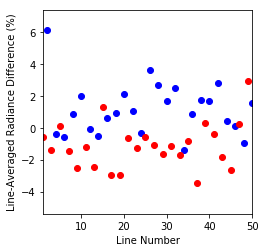

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3.75, 3.75))
plt.subplots_adjust(wspace=1.0, hspace=0)

mplxxdf[1::2].plot(ax=axes, style='bo', legend=False, ylim=(-5.4, 7.4))
mplxxdf[::2].plot(ax=axes, style='ro', legend=False, ylim=(-5.4, 7.4))

axes.set_xlabel('Line Number')
axes.set_ylabel('Line-Averaged Radiance Difference (%)')

plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/MUL-LineDiff.png')

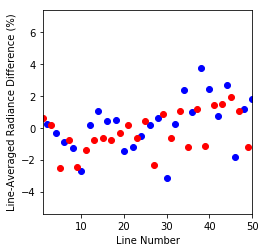

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3.75, 3.75))
plt.subplots_adjust(wspace=1.0, hspace=0)

lplxxdf[1::2].plot(ax=axes, style='bo', legend=False, ylim=(-5.4, 7.4))
lplxxdf[::2].plot(ax=axes, style='ro', legend=False, ylim=(-5.4, 7.4))

axes.set_xlabel('Line Number')
axes.set_ylabel('Line-Averaged Radiance Difference (%)')

plt.savefig('/g/data/u46/users/aw3463/PAPERS/UncExpt19/LKG-LineDiff.png')

Text(130.5, 0.5, 'Normalised radiance difference')

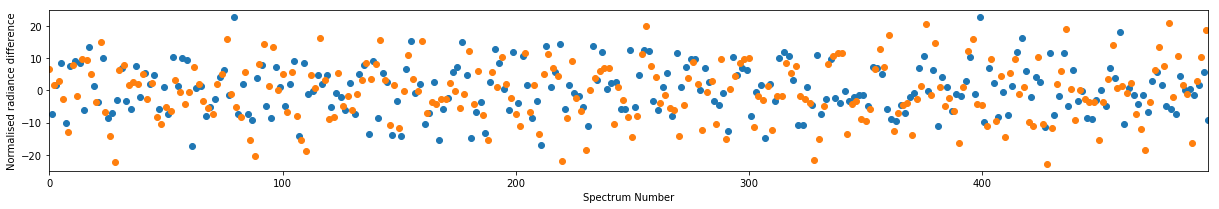

In [65]:

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(17.5, 3.5))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

mexp6g_var.iloc[1::2].plot(ax=axes, style='o', ylim=(-25, 25))
mexp6g_var.iloc[::2].plot(ax=axes, style='o', ylim=(-25, 25))

axes.set_xlabel('Spectrum Number')
axes.set_ylabel('Normalised radiance difference')


Text(130.5, 0.5, 'Normalised radiance difference')

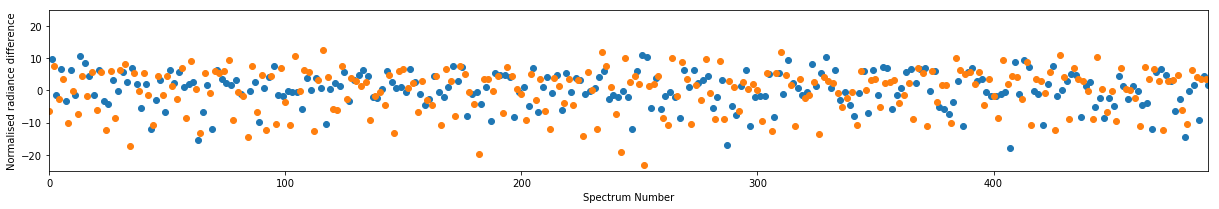

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(17.5, 3.5))
plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.0)

lexp6g_var.iloc[1::2].plot(ax=axes, style='o', ylim=(-25, 25))
lexp6g_var.iloc[::2].plot(ax=axes, style='o', ylim=(-25, 25))

axes.set_xlabel('Spectrum Number')
axes.set_ylabel('Normalised radiance difference')


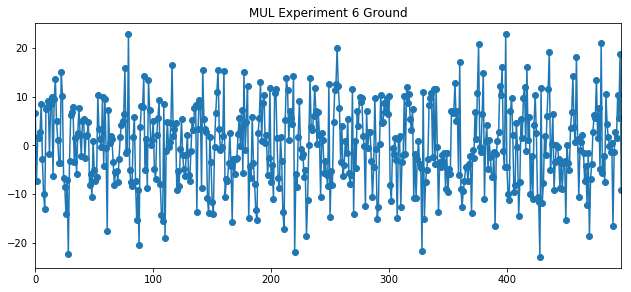

In [67]:
mexp6g_var.plot(style='-o', ylim=(-25, 25), title='MUL Experiment 6 Ground', figsize=(10.5,4.5))

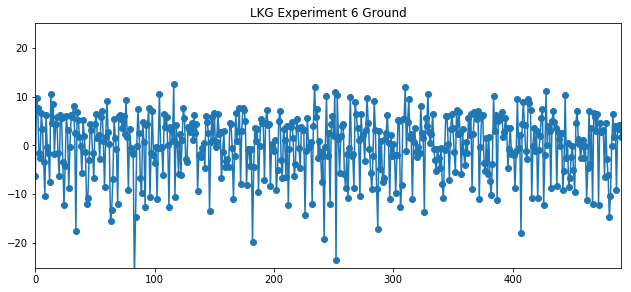

In [68]:
lexp6g_var.plot(style='-o', ylim=(-25, 25), title='LKG Experiment 6 Ground', figsize=(10.5,4.5))

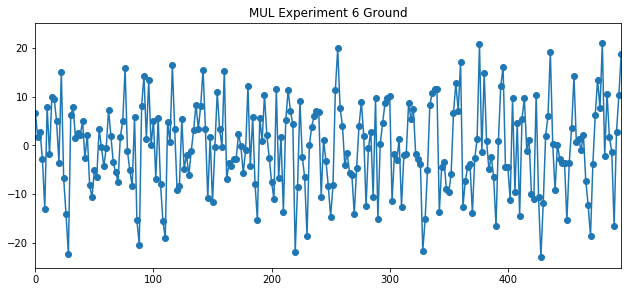

In [69]:
mexp6g_var.iloc[::2].plot(style='-o', ylim=(-25, 25), title='MUL Experiment 6 Ground', figsize=(10.5,4.5))

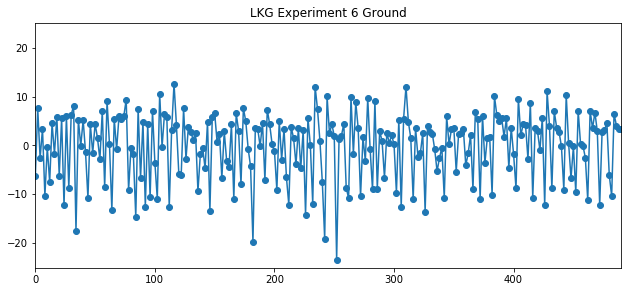

In [70]:
lexp6g_var.iloc[::2].plot(style='-o', ylim=(-25, 25), title='LKG Experiment 6 Ground', figsize=(10.5,4.5))

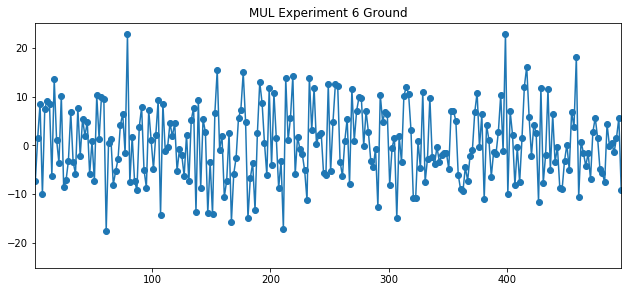

In [71]:
mexp6g_var.iloc[1::2].plot(style='-o', ylim=(-25, 25), title='MUL Experiment 6 Ground', figsize=(10.5,4.5))

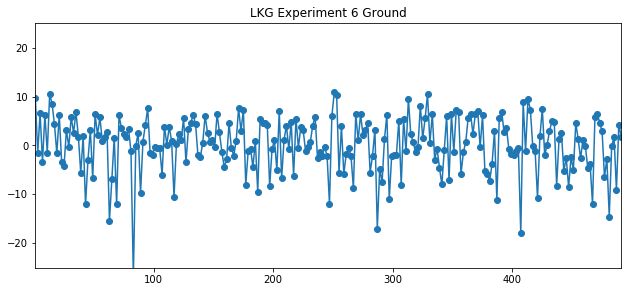

In [72]:
lexp6g_var.iloc[1::2].plot(style='-o', ylim=(-25, 25), title='LKG Experiment 6 Ground', figsize=(10.5,4.5))

In [73]:
print('Standard Deviation for Mullion Experiment 1a is', str(round(mexp1a_var.std(), 3))+'%')
print('Standard Deviation for Lake George Experiment 1a is', str(round(lexp1a_var.std(), 3))+'%')
print('Standard Deviation for Mullion Experiment 1b is', str(round(mexp1b_var.std(), 3))+'%')
print('Standard Deviation for Lake George Experiment 1b is', str(round(lexp1b_var.std(), 3))+'%')
print('Standard Deviation for Mullion Experiment 2 is', str(round(mexp2_var.std(), 3))+'%')
print('Standard Deviation for Lake George Experiment 2 is', str(round(lexp2_var.std(), 3))+'%')
print('Standard Deviation for Mullion Experiment 3 is', str(round(mexp3_var.std(), 3))+'%')
print('Standard Deviation for Lake George Experiment 3 is', str(round(lexp3_var.std(), 3))+'%')
print('Standard Deviation for Mullion Experiment 4 is', str(round(mexp4_var.std(), 3))+'%')
print('Standard Deviation for Lake George Experiment 4 is', str(round(lexp4_var.std(), 3))+'%')
print('Standard Deviation for Mullion Experiment 5 is', str(round(mexp5_var.std(), 3))+'%')
print('Standard Deviation for Lake George Experiment 5 is', str(round(lexp5_var.std(), 3))+'%')
print('Standard Deviation for Mullion Experiment 6 (panels) is', str(round(mexp6p_var.std(), 3))+'%')
print('Standard Deviation for Lake George Experiment 6 (panels) is', str(round(lexp6p_var.std(), 3))+'%')
print('Standard Deviation for Mullion Experiment 6 (grounds) is', str(round(mexp6g_var.std(), 3))+'%')
print('Standard Deviation for Lake George Experiment 6 (grounds) is', str(round(lexp6g_var.std(), 3))+'%')
print('Standard Deviation for Mullion Experiment 6 (grounds) even lines is', str(round(mexp6g_var[::2].std(), 3))+'%')
print('Standard Deviation for Lake George Experiment 6 (grounds) even lines is', str(round(lexp6g_var[::2].std(), 3))+'%')
print('Standard Deviation for Mullion Experiment 6 (grounds) odd lines is', str(round(mexp6g_var[1::2].std(), 3))+'%')
print('Standard Deviation for Lake George Experiment 6 (grounds) odd lines is', str(round(lexp6g_var[1::2].std(), 3))+'%')
print('Standard Deviation for Mullion Experiment 7 is', str(round(mexp7_var.std(), 3))+'%')

Standard Deviation for Mullion Experiment 1a is 0.065%
Standard Deviation for Lake George Experiment 1a is 0.04%
Standard Deviation for Mullion Experiment 1b is 0.054%
Standard Deviation for Lake George Experiment 1b is 0.067%
Standard Deviation for Mullion Experiment 2 is 0.101%
Standard Deviation for Lake George Experiment 2 is 0.121%
Standard Deviation for Mullion Experiment 3 is 0.134%
Standard Deviation for Lake George Experiment 3 is 0.122%
Standard Deviation for Mullion Experiment 4 is 0.145%
Standard Deviation for Lake George Experiment 4 is 0.177%
Standard Deviation for Mullion Experiment 5 is 0.243%
Standard Deviation for Lake George Experiment 5 is 0.257%
Standard Deviation for Mullion Experiment 6 (panels) is 0.207%
Standard Deviation for Lake George Experiment 6 (panels) is 0.278%
Standard Deviation for Mullion Experiment 6 (grounds) is 8.353%
Standard Deviation for Lake George Experiment 6 (grounds) is 6.308%
Standard Deviation for Mullion Experiment 6 (grounds) even line

# Figure 

### Plot ground spectra (all and good), normalised to the median good spectrum

These plots are used to identify any ground spectra that are bogus.

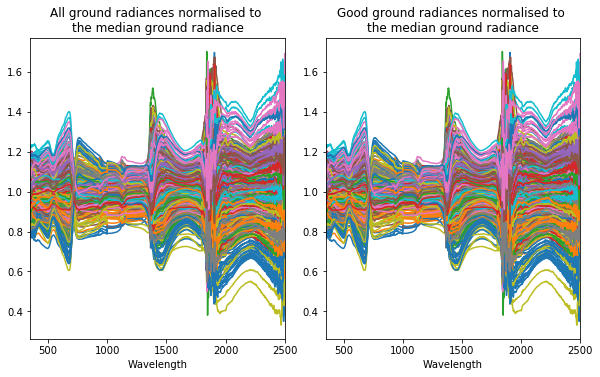

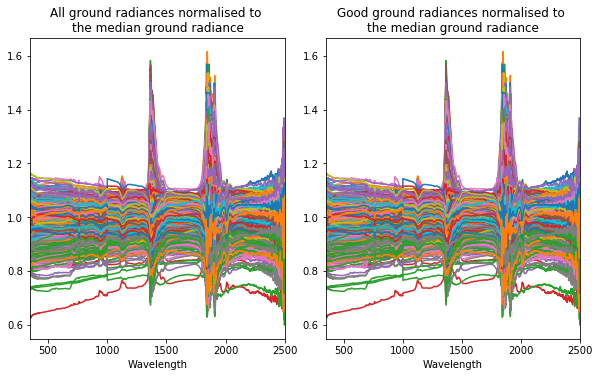

In [74]:
FIG_GroundSpectra.FIG_ground_spectra(mexp6g_spec, mexp6g_spec, moutput, mfield_data, fignum)
FIG_GroundSpectra.FIG_ground_spectra(lexp6g_spec, lexp6g_spec, loutput, lfield_data, fignum)
fignum +=1

### Add Solar angle to dataframes

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "good_panels" and<BR>
"good_grounds" dataframes.

In [75]:
mgood_panels, mgood_grounds = SolarAngle.solar_angle(mexp6p, mexp6g, mfield_data)
lgood_panels, lgood_grounds = SolarAngle.solar_angle(lexp6p, lexp6g, lfield_data)

../CalVal/SolarAngle.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  good_spectra['Solar_angle'] = 1.0
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


### Apply Panel BRF correction factor

In [76]:
mgood_panels = PanelBRF.Panel_BRF(mgood_panels, mfield_data)
lgood_panels = PanelBRF.Panel_BRF(lgood_panels, lfield_data)

### Re-Make Spectral Dataframes

After correcting good_panels for BRF, recreate the good_panel_spec and<BR>
good_panel_mean dataframes

In [77]:
mgood_panel_spec = MakeSpecDF.make_spec_df(mgood_panels, mfield_data)
mgood_panel_mean = mgood_panel_spec.mean(axis=1)

lgood_panel_spec = MakeSpecDF.make_spec_df(lgood_panels, lfield_data)
lgood_panel_mean = lgood_panel_spec.mean(axis=1)

### Create time-relative dataframes

gpt = good panels<BR>
gpta = all panels<BR>
adt = good grounds<BR>
adta = all grounds

In [78]:
mgpt, mgpta, madt, madta = CreateTimeRelativeDF.create_time_relative_dfs(mexp6p, mexp6p, mexp6g, mexp6g)
lgpt, lgpta, ladt, ladta = CreateTimeRelativeDF.create_time_relative_dfs(lexp6p, lexp6p, lexp6g, lexp6g)

# Figure 

### Plot timelines for ALL panel and ground data, with one line in one panel

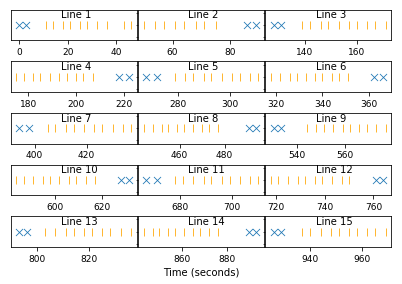

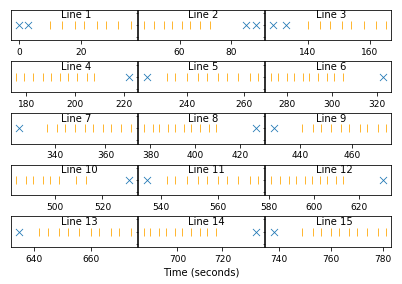

In [79]:
FIG_AllTimelines.FIG_all_timelines(mgpta, madta, moutput, mfield_data, fignum)
FIG_AllTimelines.FIG_all_timelines(lgpta, ladta, loutput, lfield_data, fignum)
fignum += 1

# Figure 

### Plot timelines for GOOD panel and ground data, with one line in one panel

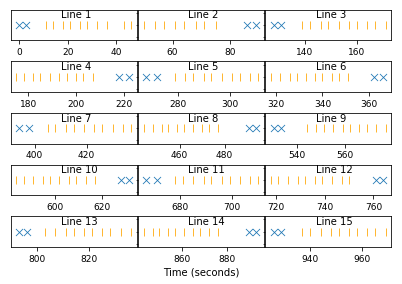

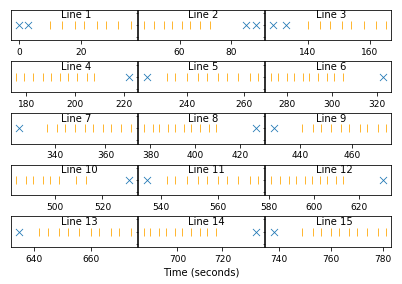

In [80]:
from CalVal.FIG_AllTimelines import panel_plot_layout, multi_timeline_plot

FIG_GoodTimelines.FIG_good_timelines(mgpta, mgpt, madt, panel_plot_layout, multi_timeline_plot, moutput, mfield_data, fignum)
FIG_GoodTimelines.FIG_good_timelines(lgpta, lgpt, ladt, panel_plot_layout, multi_timeline_plot, loutput, lfield_data, fignum)
fignum += 1

# Figure 

### Create timeline plot of averaged all/good panels

These plots are used to identify any panels that show unusually bright or dark readings,<BR>
    which can be weeded out as bad panels.
    
The general shape of the curve should follow "insolation" - the changing of incident light
due to the Sun rising/falling in the sky.

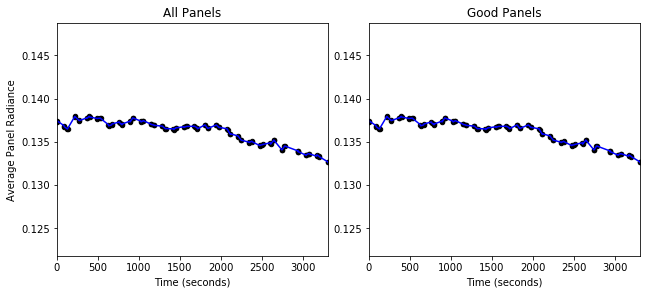

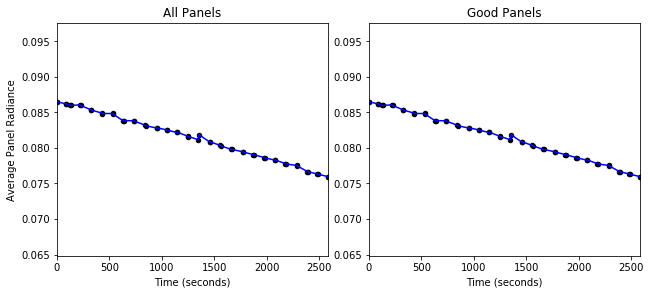

In [81]:
mgpt, mgpta = FIG_NormalisedPanelsTimeline.normalise_spectra(mexp6p_mean, mexp6p_spec, mexp6p_spec, mgpt, mgpta, mfield_data)

FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(mgpt, mgpta, moutput, mfield_data, fignum)

lgpt, lgpta = FIG_NormalisedPanelsTimeline.normalise_spectra(lexp6p_mean, lexp6p_spec, lexp6p_spec, lgpt, lgpta, lfield_data)

FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(lgpt, lgpta, loutput, lfield_data, fignum)

fignum += 1

# Figure
### Fit Insolation Curve

Given that the total radiance (insolation, I) should increase with decreasing Solar zenith angle<BR>
(ie. as the Sun rises) and that I \propto cos(Solar zenith angle), we can fit the panel data to a<BR>
straight line. The ratio between the fit and the data points can then be used to adjust all panel
and ground spectra to account for insolation.<BR><BR>

Once the fit has been calculated, the following steps are taken (in subsequent cells):
<OL>
    <LI>The ratio between the fit and each averaged panel masurement is divided off the panels, so
        that they will all fall along the same line.
    <LI>For each Line (ie. walked Line in the field), the average panel spectrum is determined, as 
        well as the average panel Solar angle.
    <LI>The "Solar angle distance" for each ground spectrum to the averaged panel Solar angle is 
        used to divide off the insolation fit from the ground spectra. 

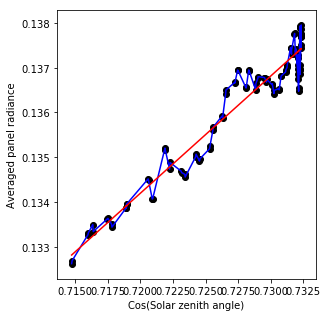

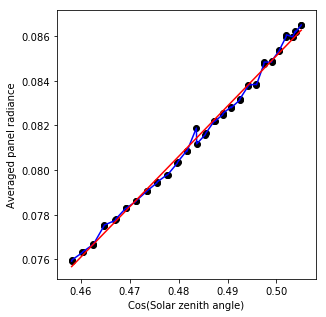

In [82]:
mslope, mintercept, mcoszenith = FIG_InsolationFit.FIG_insolation_fit(mgpt, moutput, mfield_data, fignum)
lslope, lintercept, lcoszenith = FIG_InsolationFit.FIG_insolation_fit(lgpt, loutput, lfield_data, fignum)
fignum += 1

### Scale good panels to insolation curve

Use the fitted insolation curve to determine individual offsets for each panel measurement and then divide<BR>
off the differences. This effectively removes any individual variations in the absolute scaling of panel<BR>
measurements.

In [83]:
mgood_panels = ScalePanels.scale_panels(mslope, mintercept, mcoszenith, mgpt, mgood_panels, mfield_data)
lgood_panels = ScalePanels.scale_panels(lslope, lintercept, lcoszenith, lgpt, lgood_panels, lfield_data)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


### Scale ground spectra to insolation curve

For each line, calculate the mean panel spectrum and determine the fit at the according mean Solar zenith angle.<BR>
Then determine individual fits for all ground data within the line and apply the ratio of the panel mean fit to<BR>
ground fit to the good_grounds dataframe.

In [84]:
count=0

for i in mgood_grounds.Line.unique():
    mmean_panel_fit = mslope*(np.cos(np.deg2rad(mgood_panels[mgood_panels['Line']==i].Solar_angle.mean())))+mintercept
    mgood_grounds_fit = mslope*(np.cos(np.deg2rad(mgood_grounds[mgood_grounds['Line']==i].Solar_angle)))+mintercept
    if count==0:
        pan_ground_ratio = mmean_panel_fit/mgood_grounds_fit
    else:
        pan_ground_ratio = pan_ground_ratio.append(mmean_panel_fit/mgood_grounds_fit)
    count+=1

mgood_grounds.radiance = mgood_grounds.radiance.multiply(pan_ground_ratio)

In [85]:
count=0

for i in lgood_grounds.Line.unique():
    lmean_panel_fit = lslope*(np.cos(np.deg2rad(lgood_panels[lgood_panels['Line']==i].Solar_angle.mean())))+lintercept
    lgood_grounds_fit = lslope*(np.cos(np.deg2rad(lgood_grounds[lgood_grounds['Line']==i].Solar_angle)))+lintercept
    if count==0:
        pan_ground_ratio = lmean_panel_fit/lgood_grounds_fit
    else:
        pan_ground_ratio = pan_ground_ratio.append(lmean_panel_fit/lgood_grounds_fit)
    count+=1

lgood_grounds.radiance = lgood_grounds.radiance.multiply(pan_ground_ratio)

### Define the K-factor

This reads a standard file with a response curve for the detector, given an ideally white surface.<BR>
Then "k_f" is defined for the K-factor.

In [86]:
k_f = KFactor.k_factor(panel_dir, in_panel)

### Re-Make Spectral Dataframes

After re-scaling of both good_panels and good_grounds, recreate the good_panel_spec and<BR>
good_grounds_spec dataframes

In [87]:
mgood_panel_spec = MakeSpecDF.make_spec_df(mgood_panels, mfield_data)
mgood_grounds_spec = MakeSpecDF.make_spec_df(mgood_grounds, mfield_data)

lgood_panel_spec = MakeSpecDF.make_spec_df(lgood_panels, lfield_data)
lgood_grounds_spec = MakeSpecDF.make_spec_df(lgood_grounds, lfield_data)

### Rename the first spectrum in ALL/GOOD panels to the correct name

Rather than just "radiance", it will be named something like radiance1-0<BR>
for the zeroth spectrum in the first line, for example.    

In [88]:
SpecRename.spec_rename(mgood_panel_spec, mgood_grounds_spec, firstGoodLine, firstGoodPanelSpec, firstGoodGroundSpec, mfield_data)
SpecRename.spec_rename(lgood_panel_spec, lgood_grounds_spec, firstGoodLine, firstGoodPanelSpec, firstGoodGroundSpec, lfield_data)

### Create dataframe with Reflectances

In [89]:
mall_refls = CreateReflectances.create_reflectances(mgood_panels, mgood_panel_spec, mgood_grounds_spec, k_f, mfield_data)
lall_refls = CreateReflectances.create_reflectances(lgood_panels, lgood_panel_spec, lgood_grounds_spec, k_f, lfield_data)

### Test for reflectances
Test field_data to see if the data were saved as reflectances. If so, bypass all the panelling workflow.

In [90]:
if mfield_data[5] == 'Reflectance':
    mall_refls = mgood_grounds_spec
    
if lfield_data[5] == 'Reflectance':
    lall_refls = lgood_grounds_spec

In [91]:
mall_refls['Median'] = mall_refls.median(axis=1)
lall_refls['Median'] = lall_refls.median(axis=1)

In [92]:
mnorm_refls = mall_refls.copy()
for i in mall_refls.columns:
    mnorm_refls[i] = mall_refls[i]/mall_refls['Median']
    
lnorm_refls = lall_refls.copy()
for i in lall_refls.columns:
    lnorm_refls[i] = lall_refls[i]/lall_refls['Median']

In [93]:
mnorm_refls_mean = mnorm_refls.mean(axis=0)
lnorm_refls_mean = lnorm_refls.mean(axis=0)


In [94]:
mall_refls_masked = mall_refls.copy()
for i in mall_refls.columns:
    mall_refls_masked[i] = masky(mall_refls[i])
    
mnorm_refls_masked = mnorm_refls.copy()
for i in mnorm_refls.columns:
    mnorm_refls_masked[i] = masky(mnorm_refls[i])
    
    
lall_refls_masked = lall_refls.copy()
for i in lall_refls.columns:
    lall_refls_masked[i] = masky(lall_refls[i])
    
lnorm_refls_masked = lnorm_refls.copy()
for i in lnorm_refls.columns:
    lnorm_refls_masked[i] = masky(lnorm_refls[i])

In [95]:
print('ALL MUL spectra STD =', mnorm_refls_masked.mean().std())
print('MUL Spectrum 3 STD =', mnorm_refls_masked.mean().filter(like='-3').std())
print('MUL Spectrum 4 STD =', mnorm_refls_masked.mean().filter(like='-4').std())
print('MUL Spectrum 5 STD =', mnorm_refls_masked.mean().filter(like='-5').std())
print('MUL Spectrum 6 STD =', mnorm_refls_masked.mean().filter(like='-6').std())
print('MUL Spectrum 7 STD =', mnorm_refls_masked.mean().filter(like='-7').std())
print('MUL Spectrum 8 STD =', mnorm_refls_masked.mean().filter(like='-8').std())
print('MUL Spectrum 9 STD =', mnorm_refls_masked.mean().filter(like='-9').std())
print('MUL Spectrum 10 STD =', mnorm_refls_masked.mean().filter(like='-10').std())
print('MUL Spectrum 11 STD =', mnorm_refls_masked.mean().filter(like='-11').std())
print('MUL Spectrum 12 STD =', mnorm_refls_masked.mean().filter(like='-12').std())
print('MUL Spectrum 13 STD =', mnorm_refls_masked.mean().filter(like='-13').std())
print('MUL Spectrum 14 STD =', mnorm_refls_masked.mean().filter(like='-14').std())
print('MUL Spectrum 15 STD =', mnorm_refls_masked.mean().filter(like='-15').std())
print('MUL Spectrum 16 STD =', mnorm_refls_masked.mean().filter(like='-16').std())
print('MUL Spectrum 17 STD =', mnorm_refls_masked.mean().filter(like='-17').std())
print('MUL Spectrum 18 STD =', mnorm_refls_masked.mean().filter(like='-18').std())
print('MUL Spectrum 19 STD =', mnorm_refls_masked.mean().filter(like='-19').std())
print('MUL Spectrum 20 STD =', mnorm_refls_masked.mean().filter(like='-20').std())
print('MUL Spectrum 21 STD =', mnorm_refls_masked.mean().filter(like='-21').std())


ALL MUL spectra STD = 0.08393757672179854
MUL Spectrum 3 STD = 0.08431801616113503
MUL Spectrum 4 STD = 0.1076304252357129
MUL Spectrum 5 STD = 0.05808845851230789
MUL Spectrum 6 STD = 0.07666628482364221
MUL Spectrum 7 STD = 0.0551565225760629
MUL Spectrum 8 STD = 0.058794871988765623
MUL Spectrum 9 STD = 0.05029069322533741
MUL Spectrum 10 STD = 0.04662843569941526
MUL Spectrum 11 STD = 0.05391361000206284
MUL Spectrum 12 STD = 0.09195670429655034
MUL Spectrum 13 STD = 0.0585593573926438
MUL Spectrum 14 STD = 0.07309342775441448
MUL Spectrum 15 STD = 0.07039274420190283
MUL Spectrum 16 STD = 0.05099171405910887
MUL Spectrum 17 STD = 0.05641875262595619
MUL Spectrum 18 STD = 0.04494769718655767
MUL Spectrum 19 STD = 0.0616128128136122
MUL Spectrum 20 STD = 0.07777758967594069
MUL Spectrum 21 STD = 0.07485039364840503


In [96]:
print('ALL LKG spectra STD =', lnorm_refls_masked.mean().std())
print('LKG Spectrum 3 STD =', lnorm_refls_masked.mean().filter(like='-3').std())
print('LKG Spectrum 4 STD =', lnorm_refls_masked.mean().filter(like='-4').std())
print('LKG Spectrum 5 STD =', lnorm_refls_masked.mean().filter(like='-5').std())
print('LKG Spectrum 6 STD =', lnorm_refls_masked.mean().filter(like='-6').std())
print('LKG Spectrum 7 STD =', lnorm_refls_masked.mean().filter(like='-7').std())
print('LKG Spectrum 8 STD =', lnorm_refls_masked.mean().filter(like='-8').std())
print('LKG Spectrum 9 STD =', lnorm_refls_masked.mean().filter(like='-9').std())
print('LKG Spectrum 10 STD =', lnorm_refls_masked.mean().filter(like='-10').std())


ALL LKG spectra STD = 0.07360112307884126
LKG Spectrum 3 STD = 0.050764232925996085
LKG Spectrum 4 STD = 0.07864580305560005
LKG Spectrum 5 STD = 0.07279670204005291
LKG Spectrum 6 STD = 0.06617823577073102
LKG Spectrum 7 STD = 0.05090227956206924
LKG Spectrum 8 STD = 0.0517575767499883
LKG Spectrum 9 STD = 0.05794650273324429
LKG Spectrum 10 STD = 0.08357200885711259


In [97]:
mall_refls.drop('Median', axis=1, inplace=True)
lall_refls.drop('Median', axis=1, inplace=True)

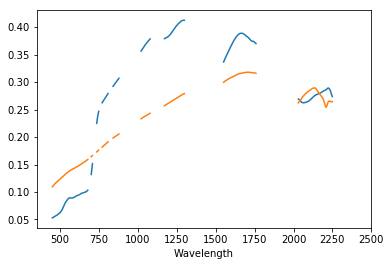

In [98]:
mall_refls_masked.filter(like='radiance4-').mean(axis=1).plot()
lall_refls_masked.filter(like='radiance4-').mean(axis=1).plot()

In [99]:
mlinenorm_refls_masked = mall_refls_masked.copy()
for i in range(1,51):
    for j in mall_refls_masked.filter(like='radiance'+str(i)+'-').columns:
        mlinenorm_refls_masked[j] = mall_refls_masked[j]/mall_refls_masked.filter(like='radiance'+str(i)+'-').mean(axis=1)
        
llinenorm_refls_masked = lall_refls_masked.copy()
for i in range(1,51):
    for j in lall_refls_masked.filter(like='radiance'+str(i)+'-').columns:
        llinenorm_refls_masked[j] = lall_refls_masked[j]/lall_refls_masked.filter(like='radiance'+str(i)+'-').mean(axis=1)


In [100]:
mlinenorm_refls_masked.filter(like='radiance1-').mean().std()
llinenorm_refls_masked.filter(like='radiance1-').mean().std()

0.058827157060234746

In [101]:
mlop = []
for i in range(1, 51):
    mlop.append(mall_refls_masked.filter(like='radiance'+str(i)+'-').mean(axis=1).std())
    
llop = []
for i in range(1, 51):
    llop.append(lall_refls_masked.filter(like='radiance'+str(i)+'-').mean(axis=1).std())

In [102]:
mloo = pd.Series(mlop)
lloo = pd.Series(llop)

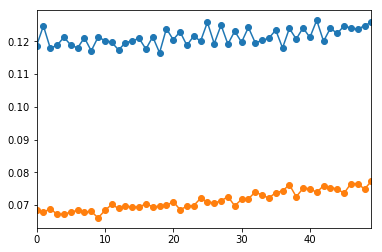

In [103]:
mloo.plot(style='-o')
plt.savefig('mlof.png')
lloo.plot(style='-o')
plt.savefig('llof.png')

In [104]:
mlopo, mlope = [], []
for i in range(len(mlop)):
    if i % 2 == 0:
        mlopo.append(mlop[i])
    else:
        mlope.append(mlop[i])
        
llopo, llope = [], []
for i in range(len(llop)):
    if i % 2 == 0:
        llopo.append(llop[i])
    else:
        llope.append(llop[i])

In [105]:
mplopo = pd.Series(mlopo)
mplope = pd.Series(mlope)
lplopo = pd.Series(llopo)
lplope = pd.Series(llope)


In [106]:
print('MUL Odd line mean, std =', mplopo.mean(), u"\u00B1", mplopo.std())
print('MUL Even line mean, std =', mplope.mean(), u"\u00B1", mplope.std())
print('LKG Odd line mean, std =', lplopo.mean(), u"\u00B1", lplopo.std())
print('LKG Even line mean, std =', lplope.mean(), u"\u00B1", lplope.std())


MUL Odd line mean, std = 0.11975375563864883 ± 0.0020303908517636023
MUL Even line mean, std = 0.12276412815930987 ± 0.002258505172533532
LKG Odd line mean, std = 0.07142136750476315 ± 0.0027673946156825113
LKG Even line mean, std = 0.07129714147321775 ± 0.0031973711903325545


In [107]:
(mplope.mean() - mplopo.mean())/mloo.mean()

0.02482598374616344

In [108]:
(lplope.mean() - lplopo.mean())/lloo.mean()

-0.0017408538308729443

# Figure 

### Plot all ground reflectances in black, plus the Line-averaged reflectances in colour

The Line-averaged reflectances are shown in order to identify any outlying lines that<BR>

might have been caused by bad panel spectra (for example).

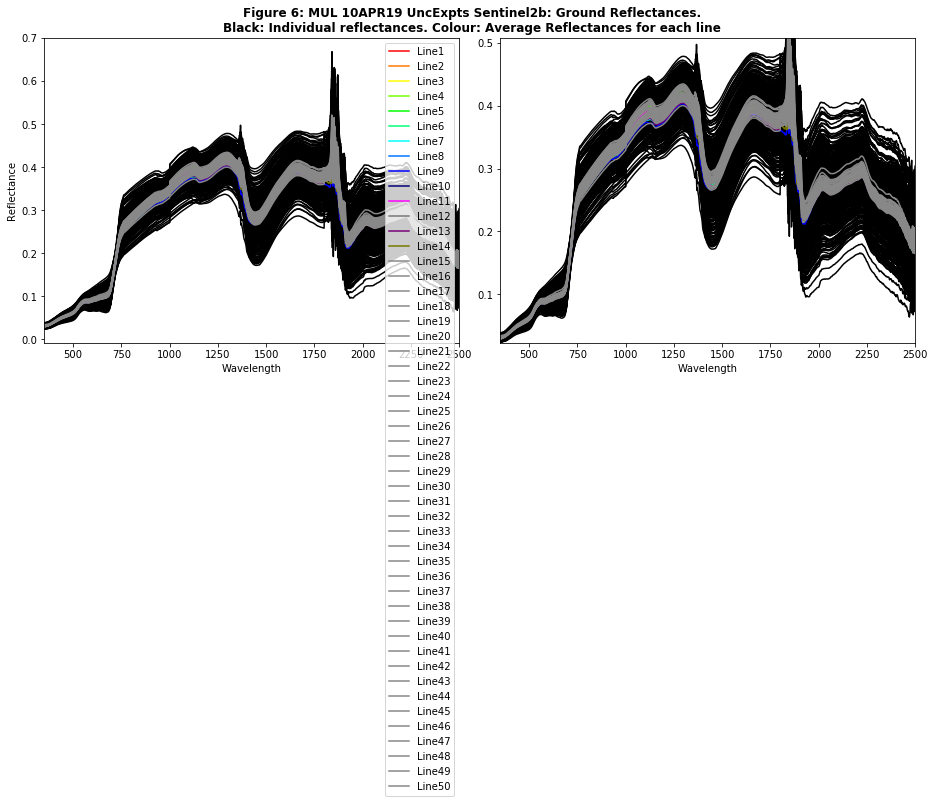

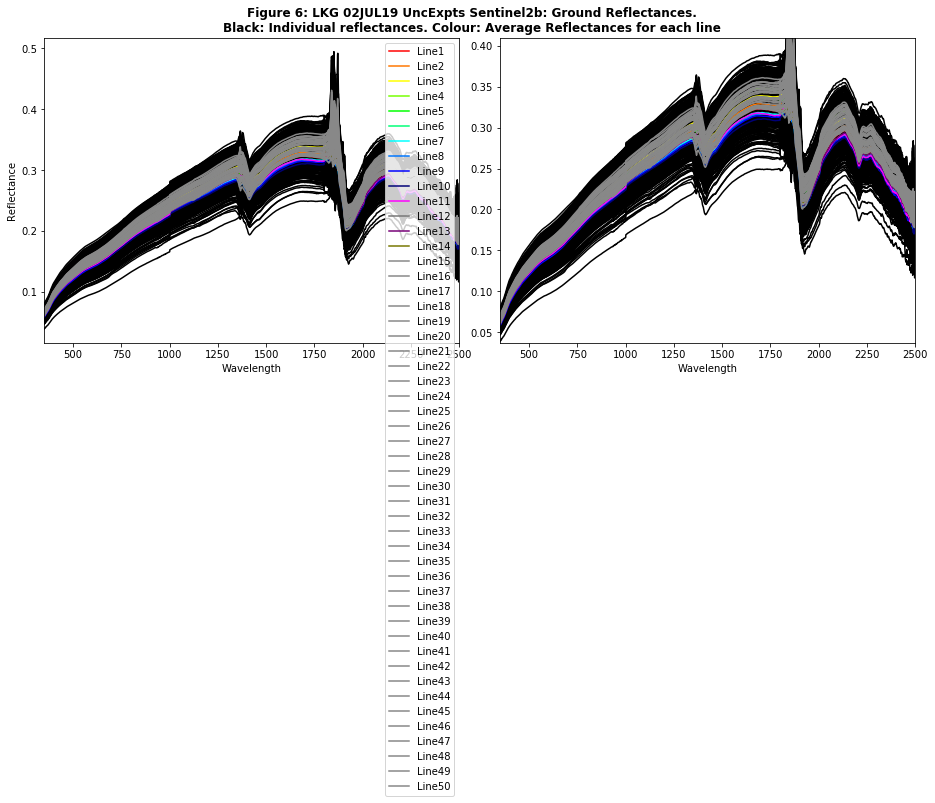

In [109]:
FIG_Reflectances.FIG_reflectances(mgood_panels, mall_refls, colpac, moutput, mfield_data, fignum)
FIG_Reflectances.FIG_reflectances(lgood_panels, lall_refls, colpac, loutput, lfield_data, fignum)
fignum += 1

### Apply weighted band responses to all reflectances

In [110]:
mls_result_df, ms2_result_df, mls_band, ms2_band = ApplyWeights.apply_weights(f_name, mall_refls, sat_resp, mfield_data)
lls_result_df, ls2_result_df, lls_band, ls2_band = ApplyWeights.apply_weights(f_name, lall_refls, sat_resp, lfield_data)

### Reformat band reflectances and apply to dataframe "ground_bands"

In [111]:
mls_ground_bands = ReformatDF.reformat_df(mgood_grounds, mls_result_df)
ms2_ground_bands = ReformatDF.reformat_df(mgood_grounds, ms2_result_df)
lls_ground_bands = ReformatDF.reformat_df(lgood_grounds, lls_result_df)
ls2_ground_bands = ReformatDF.reformat_df(lgood_grounds, ls2_result_df)

# Figure 

### Plot band reflectances

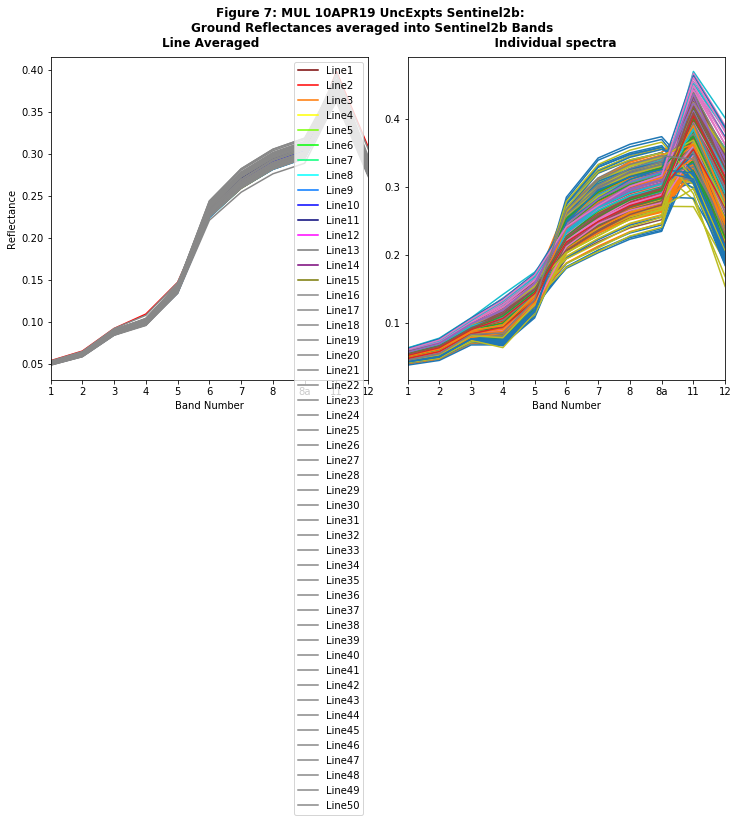

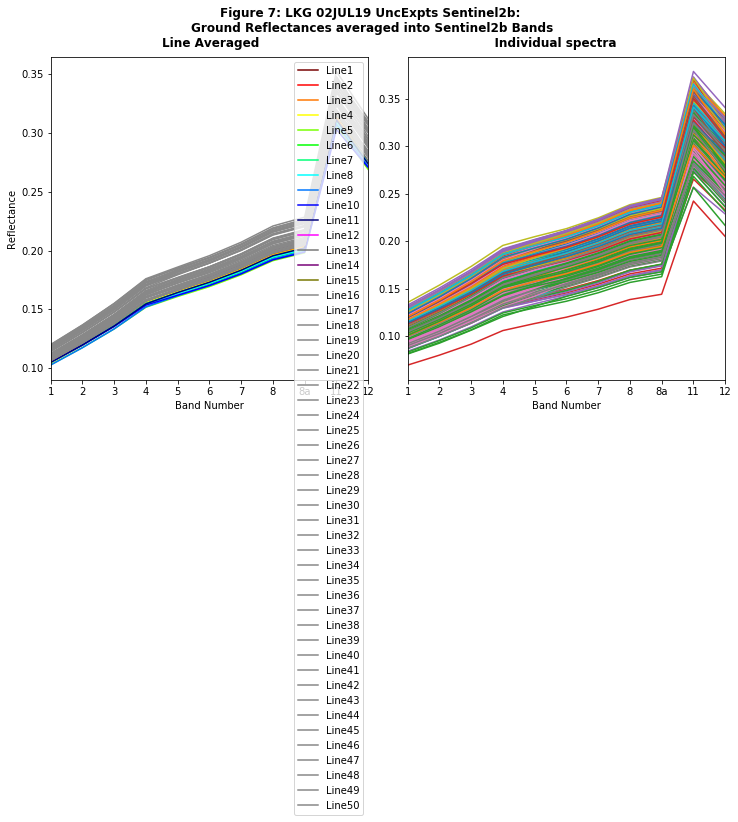

In [112]:
FIG_BandReflectances.FIG_band_reflectances(mls_ground_bands, mls_result_df, mls_band, ms2_ground_bands, ms2_result_df, ms2_band, colpac, moutput, mfield_data, fignum)
FIG_BandReflectances.FIG_band_reflectances(lls_ground_bands, lls_result_df, lls_band, ls2_ground_bands, ls2_result_df, ls2_band, colpac, loutput, lfield_data, fignum)

fignum += 1

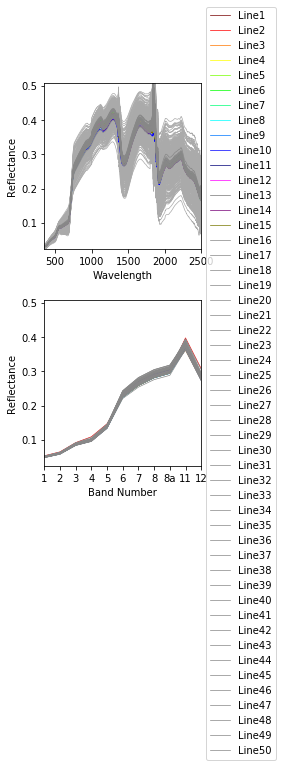

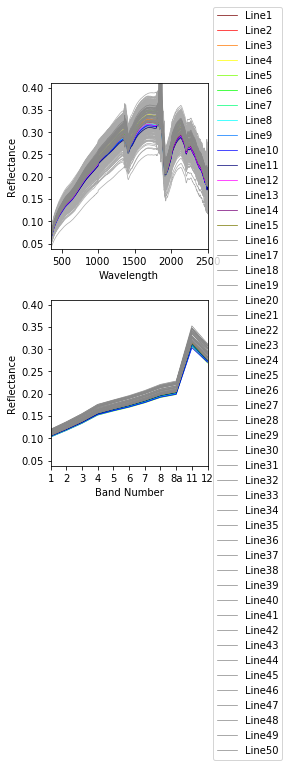

In [113]:
FIG_ReflectancesBand.FIG_reflectances_band(mls_ground_bands, mls_result_df, mls_band, ms2_ground_bands, ms2_result_df, ms2_band, mgood_panels, mall_refls, colpac, moutput, mfield_data, fignum)
FIG_ReflectancesBand.FIG_reflectances_band(lls_ground_bands, lls_result_df, lls_band, ls2_ground_bands, ls2_result_df, ls2_band, lgood_panels, lall_refls, colpac, loutput, lfield_data, fignum)

fignum += 1

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

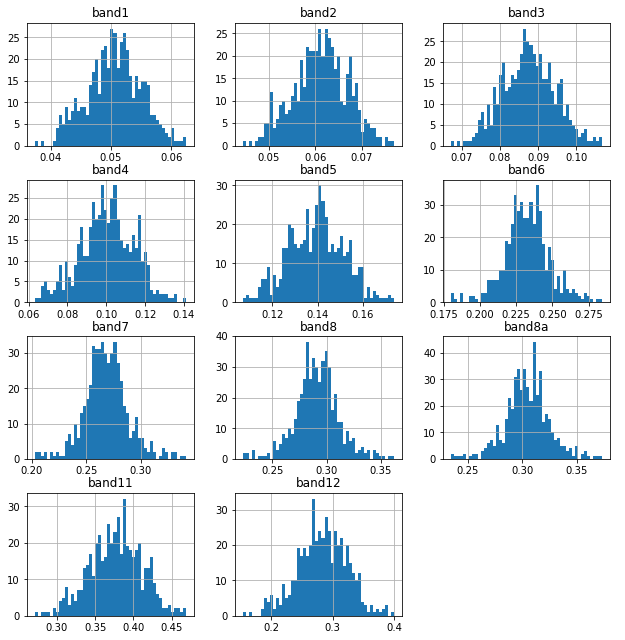

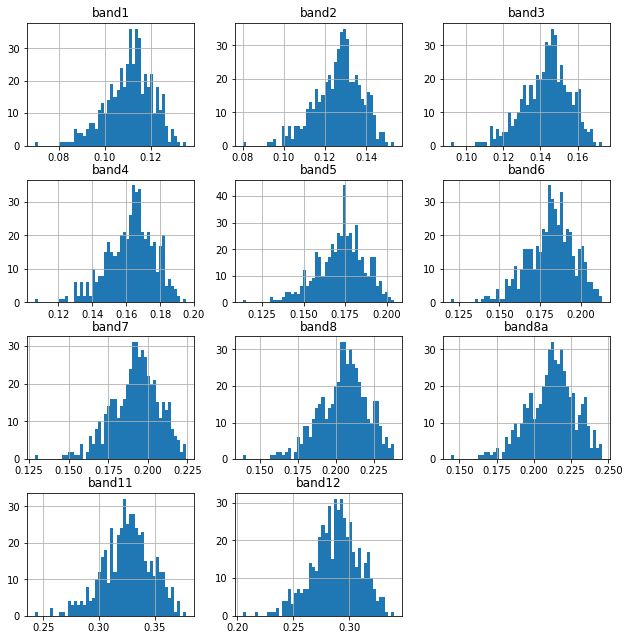

In [114]:
FIG_SpecHistogram.FIG_spec_histogram(mls_ground_bands, ms2_ground_bands, moutput, mfield_data, fignum)
FIG_SpecHistogram.FIG_spec_histogram(lls_ground_bands, ls2_ground_bands, loutput, lfield_data, fignum)
fignum += 1

### Outlying ground spectra

Display the spectra with maximum and minimum values. These can be compared to the histograms above<BR>
    to identify any outlying spectra that need to be identified as bad ground spectra.

In [115]:
OutlyingSpec.outlying_spec(mls_ground_bands, ms2_ground_bands, mfield_data)
OutlyingSpec.outlying_spec(lls_ground_bands, ls2_ground_bands, lfield_data)

Maximum value found in: mul_exp6ln4100003.asd.rad 
 band1     0.062511
band2     0.076994
band3     0.106788
band4     0.141264
band5     0.174068
band6     0.230575
band7     0.260190
band8     0.288735
band8a    0.304919
band11    0.469354
band12    0.400733
Name: 399, dtype: float64 
Minimum value found in: mul_exp6ln2300004.asd.rad 
 band1     0.037353
band2     0.044287
band3     0.067040
band4     0.067182
band5     0.106734
band6     0.217845
band7     0.256479
band8     0.274382
band8a    0.284657
band11    0.282885
band12    0.202258
Name: 220, dtype: float64
Maximum value found in: lkg_exp6ln4400006.asd.rad 
 band1     0.135375
band2     0.153663
band3     0.173325
band4     0.195464
band5     0.204663
band6     0.213100
band7     0.224400
band8     0.238335
band8a    0.245949
band11    0.369593
band12    0.333838
Name: 428, dtype: float64 
Minimum value found in: lkg_exp6ln0900010.asd.rad 
 band1     0.069547
band2     0.080018
band3     0.091572
band4     0.105901
band5    

### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [116]:
from CalVal.SolarAngle import solang
mls_ground_bands['Solar_angle'] = mls_ground_bands.apply(solang, axis=1)
ms2_ground_bands['Solar_angle'] = ms2_ground_bands.apply(solang, axis=1)
lls_ground_bands['Solar_angle'] = lls_ground_bands.apply(solang, axis=1)
ls2_ground_bands['Solar_angle'] = ls2_ground_bands.apply(solang, axis=1)

In [117]:
meves, modds = [], []
for i in ms2_ground_bands.Line.unique():
    if i%2==0:
        meves.append(ms2_ground_bands[ms2_ground_bands.Line==i].band2.mean())
    else:
        modds.append(ms2_ground_bands[ms2_ground_bands.Line==i].band2.mean())
        
mpeves = pd.DataFrame(meves)
mpodds = pd.DataFrame(modds)

print((mpeves.mean()-mpodds.mean())/mpodds.mean())

0    0.032496
dtype: float64


In [118]:
leves, lodds = [], []
for i in ls2_ground_bands.Line.unique():
    if i%2==0:
        leves.append(ls2_ground_bands[ls2_ground_bands.Line==i].band2.mean())
    else:
        lodds.append(ls2_ground_bands[ls2_ground_bands.Line==i].band2.mean())
        
lpeves = pd.DataFrame(leves)
lpodds = pd.DataFrame(lodds)

print((lpeves.mean()-lpodds.mean())/lpodds.mean())

0    0.013742
dtype: float64


### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [119]:
mls_ground_brdf, ms2_ground_brdf, mhb, mbr = BRDF.ReadAndCalc(mbrdf_data, mls_ground_bands, ms2_ground_bands, mfield_data)
lls_ground_brdf, ls2_ground_brdf, lhb, lbr = BRDF.ReadAndCalc(lbrdf_data, lls_ground_bands, ls2_ground_bands, lfield_data)

In [120]:
mbrdf_eves, mbrdf_odds = [], []
for i in ms2_ground_brdf.Line.unique():
    if i%2==0:
        mbrdf_eves.append(ms2_ground_brdf[ms2_ground_brdf.Line==i].band2.mean())
    else:
        mbrdf_odds.append(ms2_ground_brdf[ms2_ground_brdf.Line==i].band2.mean())
        
mbrdf_peves = pd.DataFrame(meves)
mbrdf_podds = pd.DataFrame(modds)

print((mbrdf_peves.mean()-mbrdf_podds.mean())/mbrdf_podds.mean())

0    0.032496
dtype: float64


In [121]:
lbrdf_eves, lbrdf_odds = [], []
for i in ls2_ground_brdf.Line.unique():
    if i%2==0:
        lbrdf_eves.append(ls2_ground_brdf[ls2_ground_brdf.Line==i].band2.mean())
    else:
        lbrdf_odds.append(ls2_ground_brdf[ls2_ground_brdf.Line==i].band2.mean())
        
lbrdf_peves = pd.DataFrame(leves)
lbrdf_podds = pd.DataFrame(lodds)

print((lbrdf_peves.mean()-lbrdf_podds.mean())/lbrdf_podds.mean())

0    0.013742
dtype: float64


In [122]:
mls_ground_brdf.filter(like='band').columns
lls_ground_brdf.filter(like='band').columns

Index(['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7'], dtype='object')

In [123]:
def oddeve(ls_ground_brdf):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(9.5, 9.5))
    plt.tight_layout(pad=3.5, w_pad=1.0, h_pad=1.5)

    jcount=0
    for j in ls_ground_brdf.filter(like='band').columns:
        brdfs = []
        for i in ls_ground_brdf.Line.unique():
            brdfs.append(ls_ground_brdf[ls_ground_brdf.Line==i][j].mean())

        prdfs = pd.DataFrame(brdfs)

        prdfs.plot(style='-o', ax=axes[int(jcount/3),jcount%3], title=j, legend=False)
        jcount+=1

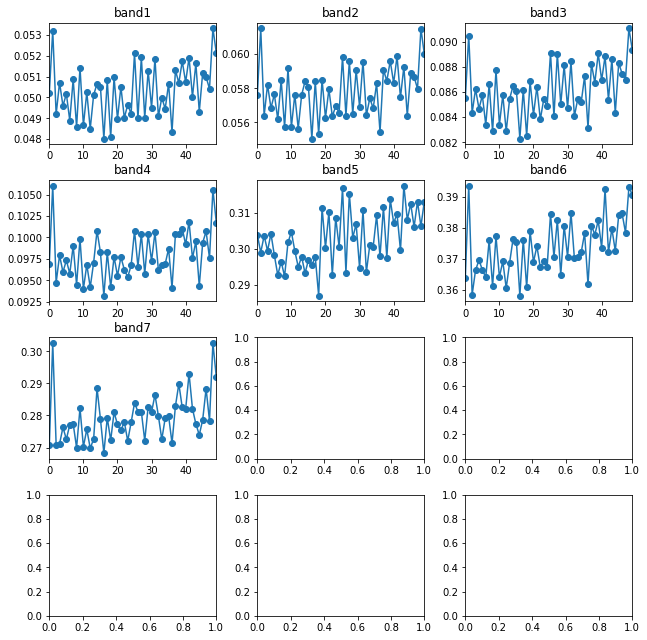

In [124]:
oddeve(mls_ground_brdf)

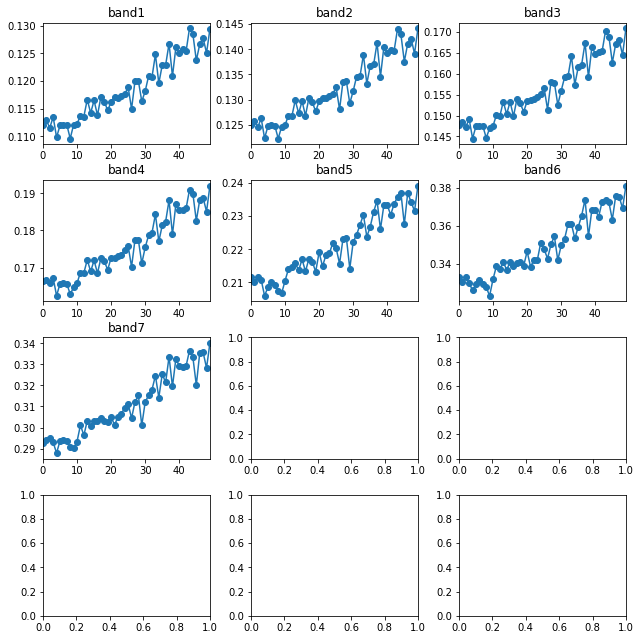

In [125]:
oddeve(lls_ground_brdf)

In [126]:
def norm_line_avg_plot(ls_ground_brdf):
    ls_norm_brdf = ls_ground_brdf.copy()

    for i in ls_norm_brdf.filter(like='band').columns:
        ls_norm_brdf[i] = ls_ground_brdf[i]/ls_ground_brdf[i].mean()

    ppro = pd.DataFrame()

    for i in ls_norm_brdf.Line.unique():
        ppro[i] = (ls_norm_brdf[ls_norm_brdf.Line==i].filter(like='band').mean().values-1)*100

    ppro.set_index(ls_norm_brdf.filter(like='band').columns, inplace=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11.5, 4.5))
    plt.tight_layout(pad=1.5, w_pad=2.0, h_pad=1.0)

    axes[0].set_xlabel('Line Number')
    axes[1].set_xlabel('Line Number')

    ppro.mean().plot(style='-o', ax=axes[0], title='Average normalised ratio over all bands (%)', color=colpac)
    ppro.T.plot(style='-o', ax=axes[1], title='Normalised ratio from band mean over entire field site (%)', color=colpac)
    axes[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    


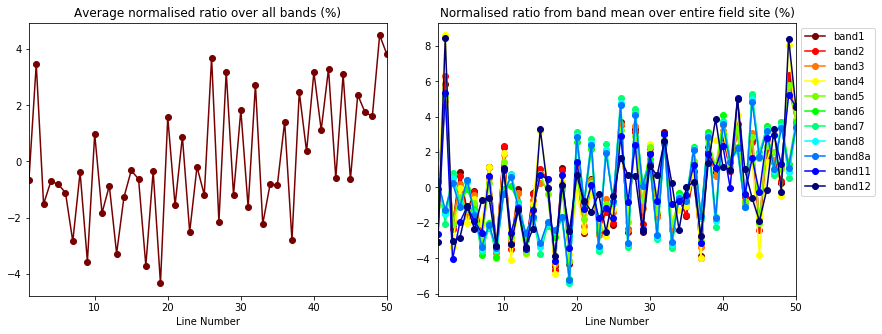

In [127]:
norm_line_avg_plot(ms2_ground_brdf)
plt.savefig('mttzz.png')

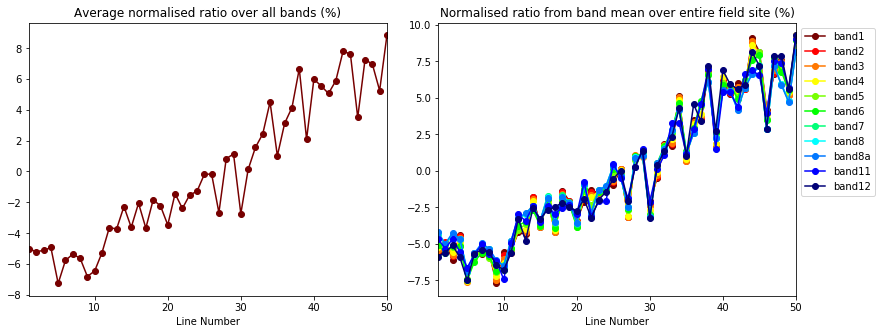

In [128]:
norm_line_avg_plot(ls2_ground_brdf)
plt.savefig('lttzz.png')

### Choose bands for Landsat 8 and Sentinel satellite data

In [129]:
from CalVal.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if mfield_data[3] == 'Landsat8':
    mband_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    mband_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif mfield_data[3] == 'Sentinel2a' or mfield_data[3] == 'Sentinel2b':
    mband_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    mband_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', mfield_data[3])
    
    
if lfield_data[3] == 'Landsat8':
    lband_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    lband_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif lfield_data[3] == 'Sentinel2a' or lfield_data[3] == 'Sentinel2b':
    lband_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    lband_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', lfield_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

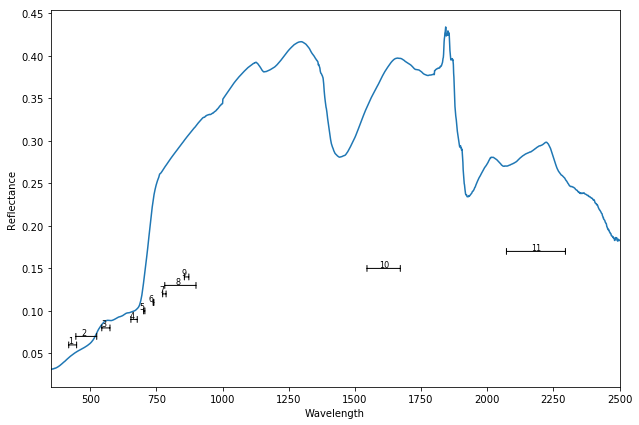

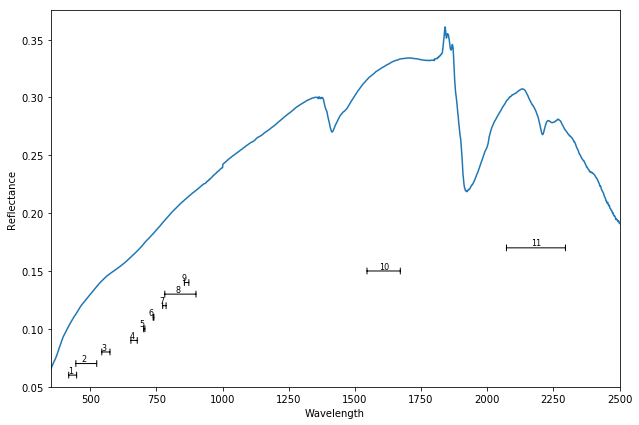

In [130]:
FIG_BandExtents.FIG_band_extents(mall_refls, mband_min, mband_max, moutput, mfield_data, fignum)
FIG_BandExtents.FIG_band_extents(lall_refls, lband_min, lband_max, loutput, lfield_data, fignum)
fignum += 1

### Fudge GPS locations if none exist

In [131]:
mls_ground_brdf = FudgeGPS.fudge_gps(mls_ground_brdf, mCorners, RockWalk, StartCorner)
ms2_ground_brdf = FudgeGPS.fudge_gps(ms2_ground_brdf, mCorners, RockWalk, StartCorner)
lls_ground_brdf = FudgeGPS.fudge_gps(lls_ground_brdf, lCorners, RockWalk, StartCorner)
ls2_ground_brdf = FudgeGPS.fudge_gps(ls2_ground_brdf, lCorners, RockWalk, StartCorner)

Assuming good GPS Coordinates, continuing...
Assuming good GPS Coordinates, continuing...
No good GPS Coordinates found, fudging...
No good GPS Coordinates found, fudging...


### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.<BR>
ls8_usgs_array will contain the USGS Level 2 product of Landsat 8 data.<BR>
ls8_usgs_bigarray will be the larger version of ls8_usgs_array.<P>
    
BRDF data is sourced/applied from satellite yaml file to match field and satellite processing for Landsat 8.<BR>
ground_WSbrdf is the brdf calculated for the whole of scene (based on satellite yaml file).

In [132]:
mls_sat_array, mls_sat_bigarray, ms2_sat_array, ms2_sat_bigarray, mls8_usgs_array, lls8_usgs_bigarray, msolar_zenith,\
mls_query, ms2_query, mls_dc, ms2_dc, mls_ground_WSbrdf = QueryAndCreate.query_and_create(mls_ground_brdf, ms2_ground_brdf, mls_ground_bands, ms2_ground_bands, mfield_data, mCorners, RockWalk, StartCorner)

lls_sat_array, lls_sat_bigarray, ls2_sat_array, ls2_sat_bigarray, lls8_usgs_array, mls8_usgs_bigarray, lsolar_zenith,\
lls_query, ls2_query, lls_dc, ls2_dc, lls_ground_WSbrdf = QueryAndCreate.query_and_create(lls_ground_brdf, ls2_ground_brdf, lls_ground_bands, ls2_ground_bands, lfield_data, lCorners, RockWalk, StartCorner)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series

Assuming good GPS Coordinates, continuing...


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series

No good GPS Coordinates found, fudging...


# Figure 

### Plot relative locations of field and satellite data

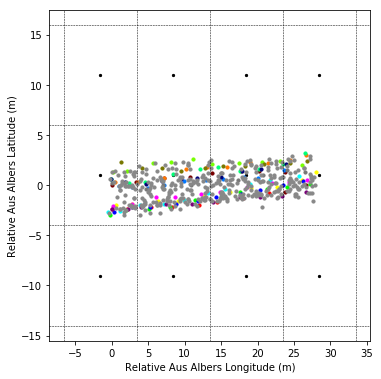

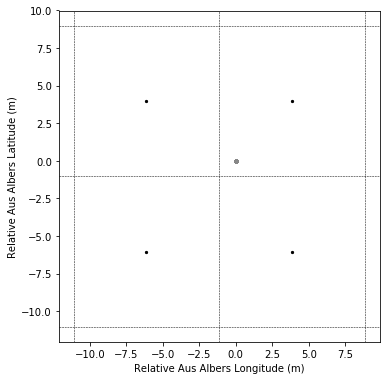

In [133]:
mls_xloc, ms2_xloc = FIG_SatFieldLocations.FIG_sat_field_locations(mls_ground_brdf, ms2_ground_brdf, mls_sat_array, ms2_sat_array, colpac, moutput, mfield_data, fignum)
lls_xloc, ls2_xloc = FIG_SatFieldLocations.FIG_sat_field_locations(lls_ground_brdf, ls2_ground_brdf, lls_sat_array, ls2_sat_array, colpac, loutput, lfield_data, fignum)
fignum +=1

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [134]:
mls_field_array, ms2_field_array = CreateFieldFromSat.create_field_from_sat(mls_sat_array, ms2_sat_array, mls_ground_brdf, ms2_ground_brdf, mls_xloc, ms2_xloc, mfield_data)
mls_field_WSarray, dummy = CreateFieldFromSat.create_field_from_sat(mls_sat_array, ms2_sat_array, mls_ground_WSbrdf, ms2_ground_brdf, mls_xloc, ms2_xloc, mfield_data)

lls_field_array, ls2_field_array = CreateFieldFromSat.create_field_from_sat(lls_sat_array, ls2_sat_array, lls_ground_brdf, ls2_ground_brdf, lls_xloc, ls2_xloc, lfield_data)
lls_field_WSarray, dummy = CreateFieldFromSat.create_field_from_sat(lls_sat_array, ls2_sat_array, lls_ground_WSbrdf, ls2_ground_brdf, lls_xloc, ls2_xloc, lfield_data)

# Figure 

### Plot large-area context RGB array for Satellite data

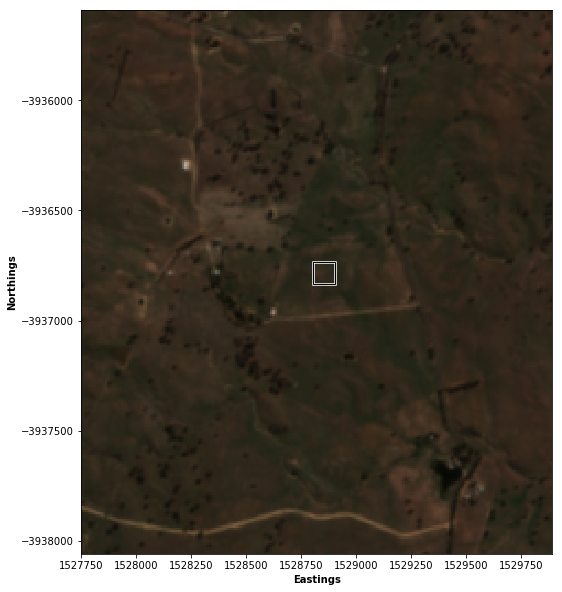

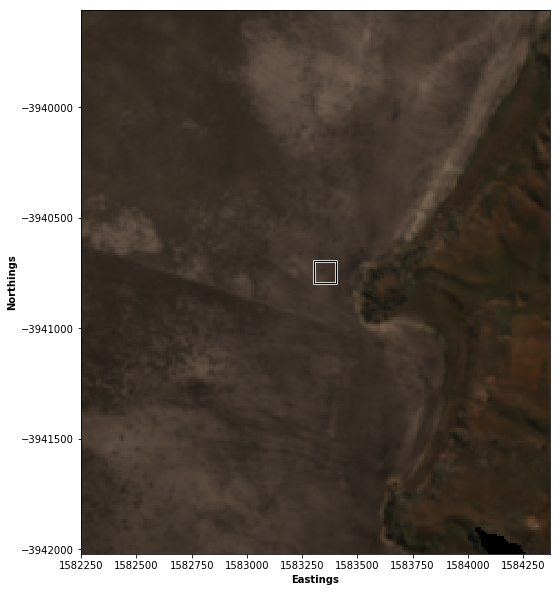

In [135]:
if mfield_data[3] == 'Landsat8':
    FIG_SatBigRGB.FIG_sat_bigRGB(mls_sat_array, mls_sat_bigarray, moutput, mfield_data, fignum)
else:
    FIG_SatBigRGB.FIG_sat_bigRGB(ms2_sat_array, ms2_sat_bigarray, moutput, mfield_data, fignum)

if lfield_data[3] == 'Landsat8':
    FIG_SatBigRGB.FIG_sat_bigRGB(lls_sat_array, lls_sat_bigarray, loutput, lfield_data, fignum)
else:
    FIG_SatBigRGB.FIG_sat_bigRGB(ls2_sat_array, ls2_sat_bigarray, loutput, lfield_data, fignum)

fignum += 1

# Figure 

### Plot RGB array for Satellite data

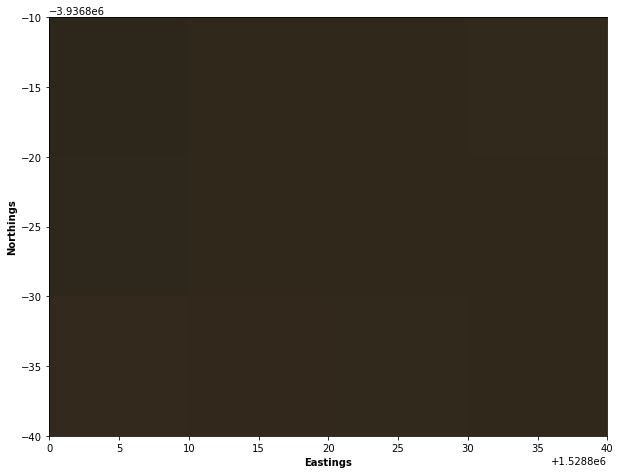

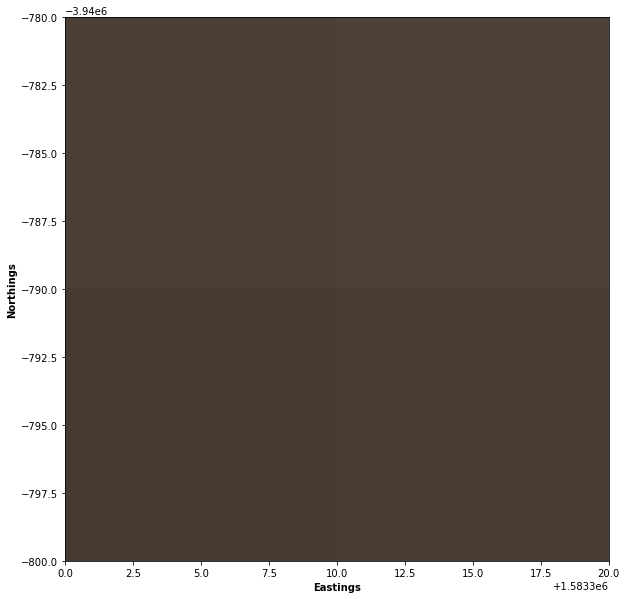

In [136]:
if mfield_data[3] == 'Landsat8':
    FIG_SatRGB.FIG_sat_RGB(mls_sat_array, moutput, mfield_data, fignum)
else:
    FIG_SatRGB.FIG_sat_RGB(ms2_sat_array, moutput, mfield_data, fignum)

if lfield_data[3] == 'Landsat8':
    FIG_SatRGB.FIG_sat_RGB(lls_sat_array, loutput, lfield_data, fignum)
else:
    FIG_SatRGB.FIG_sat_RGB(ls2_sat_array, loutput, lfield_data, fignum)

fignum += 1

# Figure 

### Plot RGB array for Field data

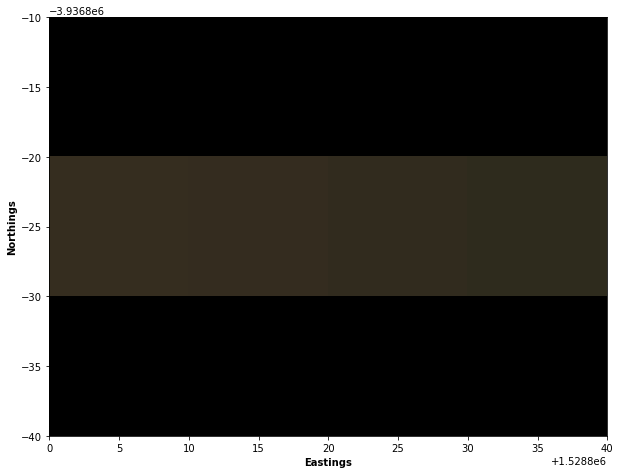

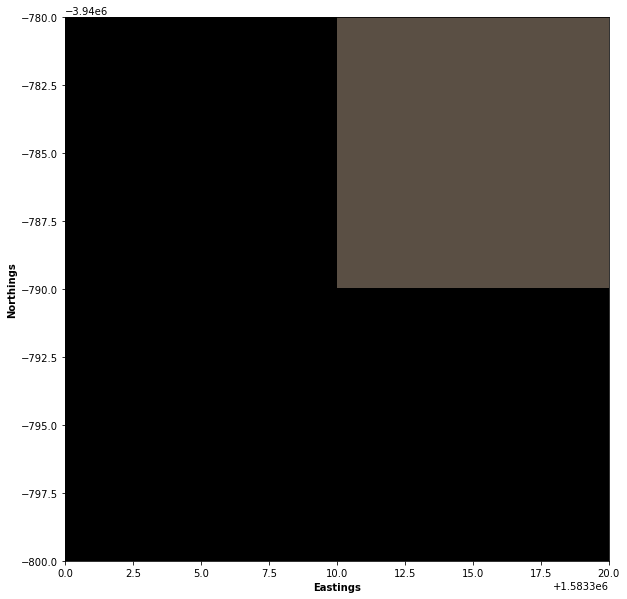

In [137]:
if mfield_data[3] == 'Landsat8':
    FIG_FieldRGB.FIG_field_RGB(mls_field_WSarray, moutput, mfield_data, fignum)
else:
    FIG_FieldRGB.FIG_field_RGB(ms2_field_array, moutput, mfield_data, fignum)

if lfield_data[3] == 'Landsat8':
    FIG_FieldRGB.FIG_field_RGB(lls_field_WSarray, loutput, lfield_data, fignum)
else:
    FIG_FieldRGB.FIG_field_RGB(ls2_field_array, loutput, lfield_data, fignum)

fignum += 1

## Figure
### Variance of satellite data

Band-by-band plots of the ratio of satellite data, divided by the mean, for each band are shown.
The title also lists the min, max and mean variance. Variance is defined as the ratio of the standard
deviation divided by the mean, for each band. The mean variance should typically be less than 5%.

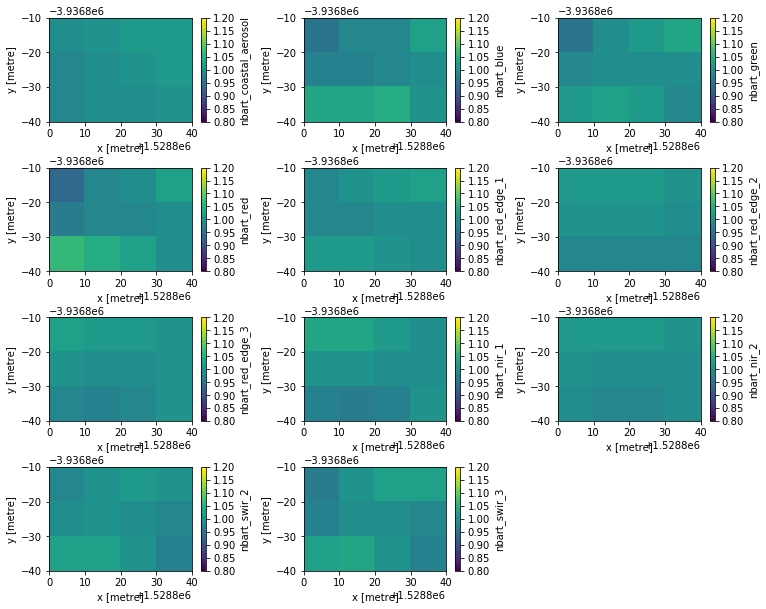

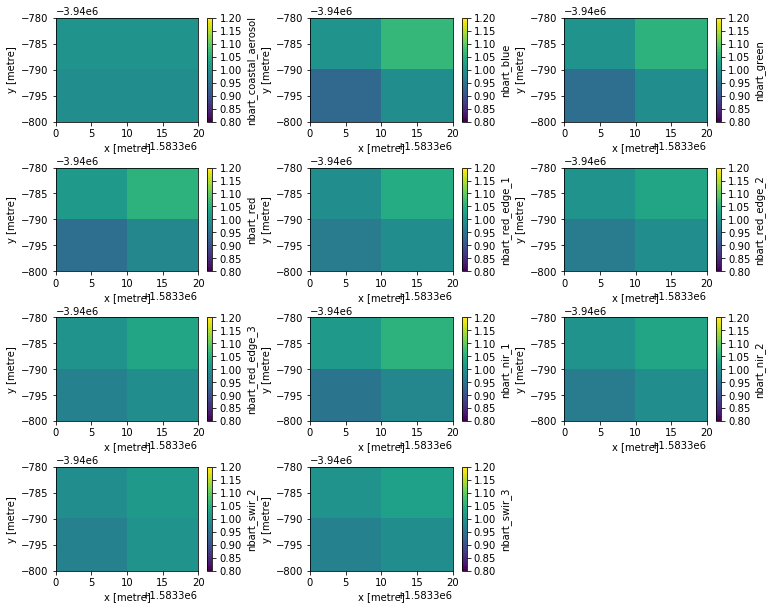

In [138]:
if mfield_data[3] == 'Landsat8':
    mvariance = FIG_SatBands.FIG_sat_bands(mls_sat_array, mls_field_WSarray, moutput, mfield_data, fignum)
else:
    mvariance = FIG_SatBands.FIG_sat_bands(ms2_sat_array, ms2_field_array, moutput, mfield_data, fignum)

if lfield_data[3] == 'Landsat8':
    lvariance = FIG_SatBands.FIG_sat_bands(lls_sat_array, lls_field_WSarray, loutput, lfield_data, fignum)
else:
    lvariance = FIG_SatBands.FIG_sat_bands(ls2_sat_array, ls2_field_array, loutput, lfield_data, fignum)

fignum += 1

# Figure

### Plot ratio arrays for each band

Each panel shows the ratio of satellite/field data.

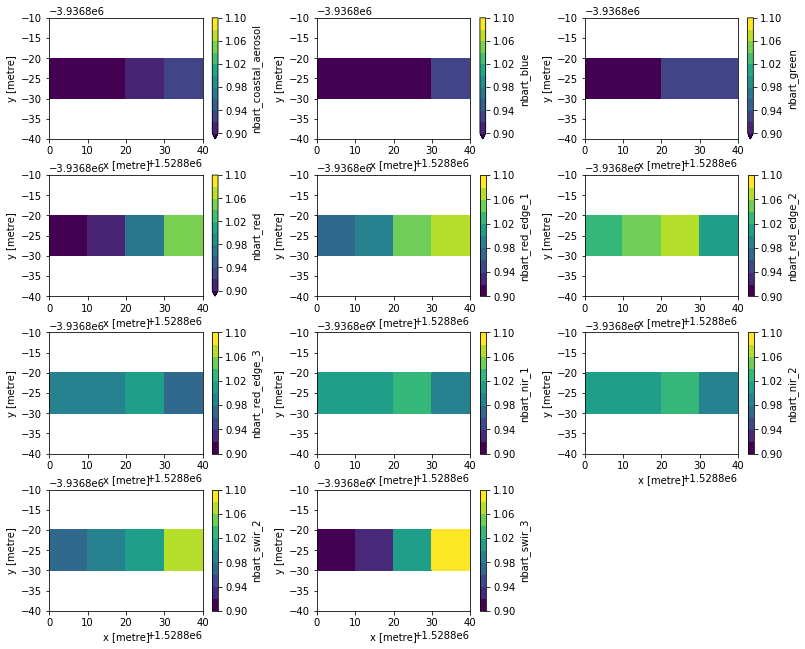

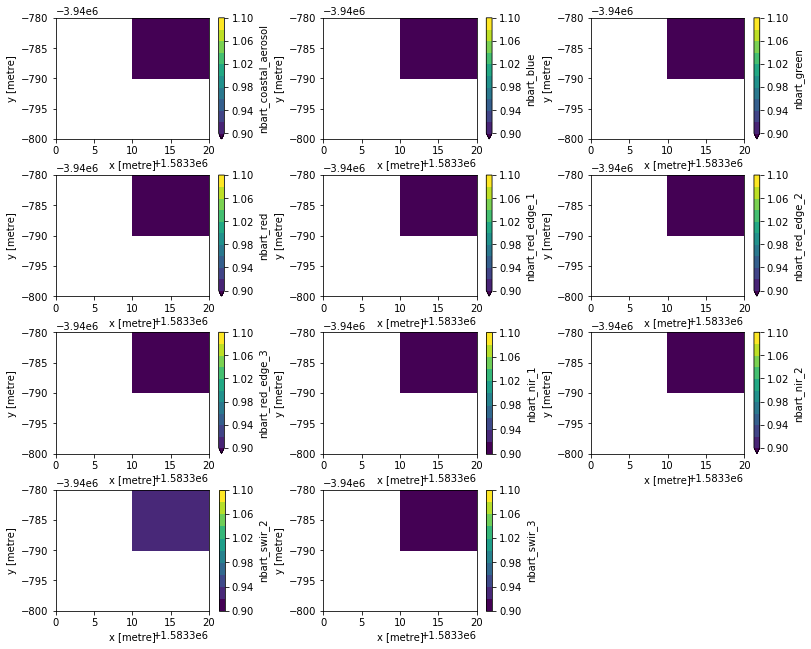

In [139]:
if mfield_data[3] == 'Landsat8':
    FIG_RatioArrays.FIG_ratio_arrays(mls_sat_array, mls_field_WSarray, moutput, mfield_data, fignum)
else:
    FIG_RatioArrays.FIG_ratio_arrays(ms2_sat_array, ms2_field_array, moutput, mfield_data, fignum)

if lfield_data[3] == 'Landsat8':
    FIG_RatioArrays.FIG_ratio_arrays(lls_sat_array, lls_field_WSarray, loutput, lfield_data, fignum)
else:
    FIG_RatioArrays.FIG_ratio_arrays(ls2_sat_array, ls2_field_array, loutput, lfield_data, fignum)

fignum += 1

### Create a statistics dataframe, comparing satellite and field data

In [140]:
mls_fstat_df, ms2_fstat_df = CreateStats.create_stats(mls_sat_array, ms2_sat_array, mls_ground_brdf, ms2_ground_brdf, mfield_data)
mls_fstat_WSdf, dummy = CreateStats.create_stats(mls_sat_array, ms2_sat_array, mls_ground_WSbrdf, ms2_ground_brdf, mfield_data)
lls_fstat_df, ls2_fstat_df = CreateStats.create_stats(lls_sat_array, ls2_sat_array, lls_ground_brdf, ls2_ground_brdf, lfield_data)
lls_fstat_WSdf, dummy = CreateStats.create_stats(lls_sat_array, ls2_sat_array, lls_ground_WSbrdf, ls2_ground_brdf, lfield_data)

if mfield_data[6] == 'USGS':
    mls_fstat_usgs_df, dummy = CreateStats.create_stats(mls8_usgs_array, ms2_sat_array, mls_ground_brdf, ms2_ground_brdf, mfield_data)
else:
    mls_fstat_usgs_df = 0
    
if lfield_data[6] == 'USGS':
    lls_fstat_usgs_df, dummy = CreateStats.create_stats(lls8_usgs_array, ls2_sat_array, lls_ground_brdf, ls2_ground_brdf, lfield_data)
else:
    lls_fstat_usgs_df = 0

## Create a statistics dataframe, comparing satellite and field data,
for only those satellite pixels which overlap with at least one field data position.

In [141]:
mls_finner_df, ms2_finner_df = CreateSubStats.create_SUB_stats(mls_sat_array, ms2_sat_array, mls_field_array, ms2_field_array, mls_ground_brdf, ms2_ground_brdf, mls_fstat_df, ms2_fstat_df, mfield_data)
mls_finner_WSdf, dummy = CreateSubStats.create_SUB_stats(mls_sat_array, ms2_sat_array, mls_field_WSarray, ms2_field_array, mls_ground_WSbrdf, ms2_ground_brdf, mls_fstat_WSdf, ms2_fstat_df, mfield_data)

lls_finner_df, ls2_finner_df = CreateSubStats.create_SUB_stats(lls_sat_array, ls2_sat_array, lls_field_array, ls2_field_array, lls_ground_brdf, ls2_ground_brdf, lls_fstat_df, ls2_fstat_df, lfield_data)
lls_finner_WSdf, dummy = CreateSubStats.create_SUB_stats(lls_sat_array, ls2_sat_array, lls_field_WSarray, ls2_field_array, lls_ground_WSbrdf, ls2_ground_brdf, lls_fstat_WSdf, ls2_fstat_df, lfield_data)

# Figure

### Plot comparison spectra of satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the satellite and field data, based on the standard deviation of the pixels
within the field. The black line shows the satellite data, which has been averaged over all pixels that satisfy the Datacube query ie. all pixels shown in Figure 11. The orange line shows satellite data which has been averaged over only those pixels that overlap with at least one field measurement.

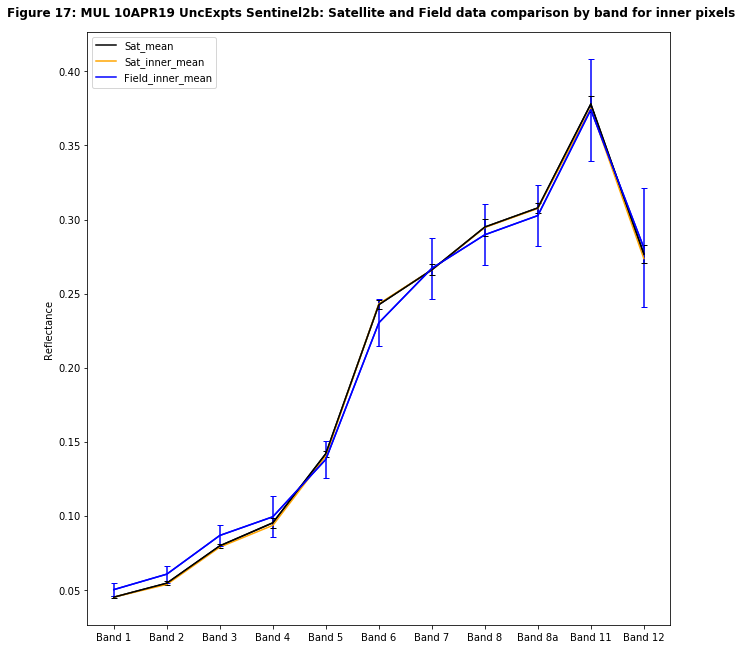

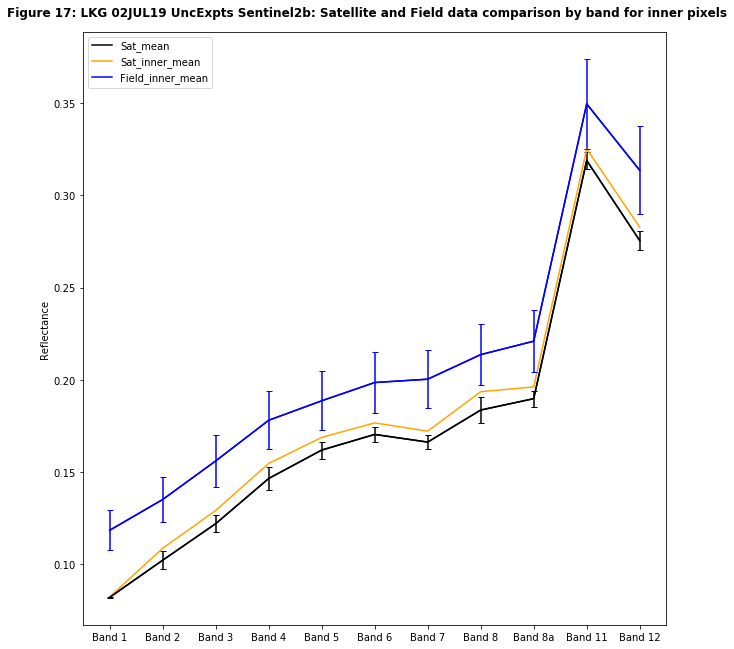

In [142]:
if mfield_data[3] == 'Landsat8':
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(mls_sat_array, mls_fstat_WSdf, mls_finner_WSdf, moutput, mfield_data, fignum)
else:
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(ms2_sat_array, ms2_fstat_df, ms2_finner_df, moutput, mfield_data, fignum)

if lfield_data[3] == 'Landsat8':
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(lls_sat_array, lls_fstat_WSdf, lls_finner_WSdf, loutput, lfield_data, fignum)
else:
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(ls2_sat_array, ls2_fstat_df, ls2_finner_df, loutput, lfield_data, fignum)

fignum += 1

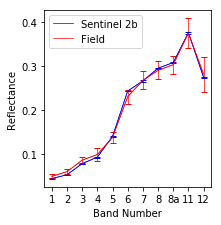

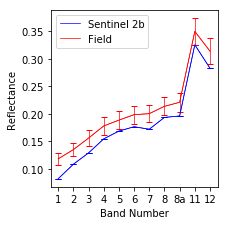

In [143]:
if mfield_data[3] == 'Landsat8':
    FIG_SatFieldBands.FIG_sat_field_bands(mls_sat_array, mls_fstat_WSdf, mls_finner_WSdf, moutput, mfield_data, fignum)
else:
    FIG_SatFieldBands.FIG_sat_field_bands(ms2_sat_array, ms2_fstat_df, ms2_finner_df, moutput, mfield_data, fignum)

if lfield_data[3] == 'Landsat8':
    FIG_SatFieldBands.FIG_sat_field_bands(lls_sat_array, lls_fstat_WSdf, lls_finner_WSdf, loutput, lfield_data, fignum)
else:
    FIG_SatFieldBands.FIG_sat_field_bands(ls2_sat_array, ls2_fstat_df, ls2_finner_df, loutput, lfield_data, fignum)

fignum += 1

# Figure

### Comparison plot of Field and satellite data

Plot shows a pixel-by-pixel comparison of all pixels where field data exists.<BR> 
Different band data are shown in different colours and different symbols.

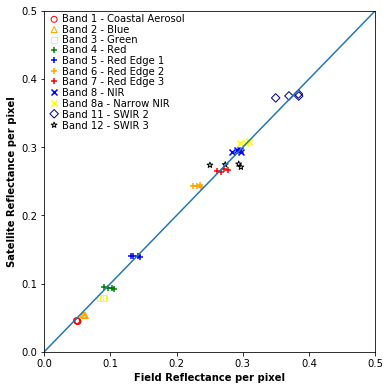

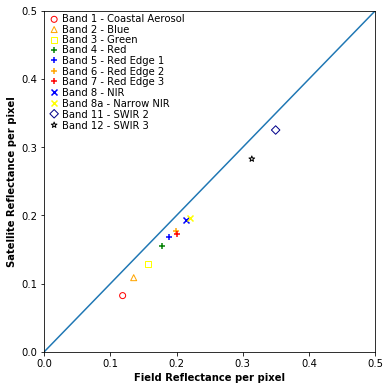

In [144]:
if mfield_data[3] == 'Landsat8':
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(mls_sat_array, mls_field_WSarray, plot_scale, moutput, mfield_data, fignum)
else:
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(ms2_sat_array, ms2_field_array, plot_scale, moutput, mfield_data, fignum)

if lfield_data[3] == 'Landsat8':
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(lls_sat_array, lls_field_WSarray, plot_scale, loutput, lfield_data, fignum)
else:
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(ls2_sat_array, ls2_field_array, plot_scale, loutput, lfield_data, fignum)

fignum += 1

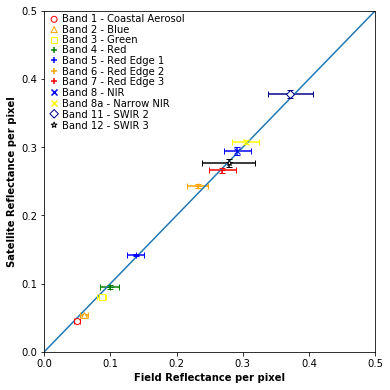

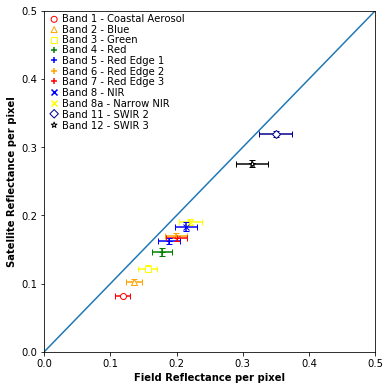

In [145]:
if mfield_data[3] == 'Landsat8':
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(mls_sat_array, mls_field_WSarray, plot_scale, mls_fstat_WSdf, moutput, mfield_data, fignum)
else:
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(ms2_sat_array, ms2_field_array, plot_scale, ms2_fstat_df, moutput, mfield_data, fignum)

if lfield_data[3] == 'Landsat8':
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(lls_sat_array, lls_field_WSarray, plot_scale, lls_fstat_WSdf, loutput, lfield_data, fignum)
else:
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(ls2_sat_array, ls2_field_array, plot_scale, ls2_fstat_df, loutput, lfield_data, fignum)

fignum += 1

## Print out summary data sheet

In [146]:
if mfield_data[3] == 'Landsat8':
    PrintSheet.print_sheet(mls_ground_WSbrdf, mls_sat_array, mls_fstat_WSdf, mindir, moutput, mfield_data, mCorners, RockWalk, StartCorner, mvariance, mls_query, mls_dc)
else:
    PrintSheet.print_sheet(ms2_ground_brdf, ms2_sat_array, ms2_fstat_df, mindir, moutput, mfield_data, mCorners, RockWalk, StartCorner, mvariance, ms2_query, ms2_dc)
    
if lfield_data[3] == 'Landsat8':
    PrintSheet.print_sheet(lls_ground_WSbrdf, lls_sat_array, lls_fstat_WSdf, lindir, loutput, lfield_data, lCorners, RockWalk, StartCorner, lvariance, lls_query, lls_dc)
else:
    PrintSheet.print_sheet(ls2_ground_brdf, ls2_sat_array, ls2_fstat_df, lindir, loutput, lfield_data, lCorners, RockWalk, StartCorner, lvariance, ls2_query, ls2_dc)

In [147]:
mall_refls.median(axis=1).to_csv('../CSV/FULL_SPEC_AVG/'+mfield_data[0]+mfield_data[1]+'.csv')
lall_refls.median(axis=1).to_csv('../CSV/FULL_SPEC_AVG/'+lfield_data[0]+lfield_data[1]+'.csv')

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [148]:
OutputCSVs.output_csvs(mls_fstat_WSdf, mls_fstat_usgs_df, ms2_fstat_df, mls_sat_array, ms2_sat_array, mls_ground_WSbrdf, ms2_ground_brdf, mfield_data)
OutputCSVs.output_csvs(lls_fstat_WSdf, lls_fstat_usgs_df, ls2_fstat_df, lls_sat_array, ls2_sat_array, lls_ground_WSbrdf, ls2_ground_brdf, lfield_data)

Difference in time between field site measurement and Sentinel data is -1 days +22:04:01.024000
Difference in time between field site measurement and Sentinel data is 6 days 21:00:18.024000


## How long did this notebook take to run?

In [149]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")

This Notebook took  0:14:10 (h:m:s) to run


This cell for Lan-Wei's CSV file of Original SR, BRDF-corrected and Whole of scene-corrected brdf.

ls_ground_WSbrdf.to_csv('../WORKDIR/CSV_4_LanWei/'+field_data[0]+'-'+field_data[1]+field_data[2]+'-WSbrdf.csv')
ls_ground_brdf.to_csv('../WORKDIR/CSV_4_LanWei/'+field_data[0]+'-'+field_data[1]+field_data[2]+'-brdf.csv')
ls_ground_bands.to_csv('../WORKDIR/CSV_4_LanWei/'+field_data[0]+'-'+field_data[1]+field_data[2]+'-bands.csv')

In [150]:
mgkr = []

for i in mls_ground_brdf.Line.unique():
    mgkr.append(mls_ground_brdf[mls_ground_brdf.Line==i].mean().values)

mpkr = pd.DataFrame(mgkr, columns=['Lat', 'Lon', 'Line', 'Spec', 'Solar Angle', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7'])

In [151]:
lgkr = []

for i in lls_ground_brdf.Line.unique():
    lgkr.append(lls_ground_brdf[lls_ground_brdf.Line==i].mean().values)

lpkr = pd.DataFrame(lgkr, columns=['Lat', 'Lon', 'Line', 'Spec', 'Solar Angle', 'band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7'])

In [152]:
100 * mpkr[::2].std()/mpkr[::2].mean()

Lat            -0.000023
Lon             0.000009
Line           58.878406
Spec            0.000000
Solar Angle     1.018417
band1           2.324434
band2           2.441088
band3           2.250374
band4           2.916695
band5           1.916234
band6           2.213574
band7           2.883835
dtype: float64

In [153]:
100 * lpkr[::2].std()/lpkr[::2].mean()

Lat           -2.301181e-14
Lon            5.822426e-14
Line           5.887841e+01
Spec           0.000000e+00
Solar Angle    1.479234e+00
band1          4.691489e+00
band2          4.643660e+00
band3          4.695956e+00
band4          4.689934e+00
band5          4.270413e+00
band6          4.400565e+00
band7          4.632380e+00
dtype: float64

In [154]:
100*(mpkr.band1[::2].mean()-mpkr.band1[1::2].mean())/mpkr.band1.mean()

-3.2092799486034234

In [155]:
100*(lpkr.band1[::2].mean()-lpkr.band1[1::2].mean())/lpkr.band1.mean()

-1.5099075011374166

In [156]:
100 * mpkr[2::6].std()/mpkr[2::6].mean()

Lat            -0.000018
Lon             0.000009
Line           61.237244
Spec            0.000000
Solar Angle     0.963007
band1           1.609256
band2           1.800211
band3           1.550716
band4           2.672710
band5           1.932449
band6           1.827750
band7           2.678202
dtype: float64

In [157]:
100 * lpkr[2::6].std()/lpkr[2::6].mean()

Lat           -2.538183e-14
Lon            0.000000e+00
Line           6.123724e+01
Spec           0.000000e+00
Solar Angle    1.462410e+00
band1          5.173662e+00
band2          5.081189e+00
band3          5.075941e+00
band4          5.027626e+00
band5          4.416555e+00
band6          4.302863e+00
band7          4.595253e+00
dtype: float64